# Find arbitrage in historical data

In [4]:
cd ..

/Users/guillaume_baquiast/Documents/tmp


In [5]:
from typing import List
import os
import glob
import tarfile
import bz2
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import datetime
import json
from unittest.mock import patch
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

In [7]:
from src.retreive_data import load_markets
from src.plotting import plot_proba_through_time

In [2]:
%matplotlib inline

In [3]:
# Change this certs path to wherever you're storing your certificates
certs_path = '/Users/guillaume_baquiast/Documents/tmp'

# Change these login details to your own
my_username = "your_email"
my_password = "your_password"
my_app_key = "your_app_key"

trading = betfairlightweight.APIClient(username=my_username,
                                       password=my_password,
                                       app_key=my_app_key,
                                       certs=certs_path)

listener = betfairlightweight.StreamListener(max_latency=None)


# Load metadata

In [29]:
df_metadata = pd.read_csv("data/champions_league_metadata.csv")
df_metadata["market_time"] = pd.to_datetime(df_metadata["market_time"], dayfirst=True)

In [30]:
df_metadata.head(2)

,event_name,event_id,market_time,open_date,path,date,league,country,winner
0,Barcelona v Paris St-G,30186199.0,2021-02-16 20:00:00,16/02/2021 20:00,/Users/guillaume_baquiast/Documents/tmp/data/B...,16/02/2021,Champions League,Europe,Paris St-G
1,RB Leipzig v Liverpool,30186224.0,2021-02-16 20:00:00,16/02/2021 20:00,/Users/guillaume_baquiast/Documents/tmp/data/B...,16/02/2021,Champions League,Europe,Liverpool


# Load game

In [31]:
from src.retreive_data import load_markets, retrieve_game_data, preprocess_game_data

In [32]:
# event_name = "Barcelona v Paris St-G"
# goal_times = [27, 32, 65, 85, 70]

event_name = "RB Leipzig v Liverpool"
goal_times = [53, 58]

start_game_date_time = df_metadata[df_metadata["event_name"]==event_name]["market_time"].tolist()[0]

In [33]:
market_paths = df_metadata[df_metadata["event_name"]==event_name]["path"].tolist()

data_dict = retrieve_game_data(market_paths)
df_game = preprocess_game_data(data_dict)

In [34]:
df_game.head()

,publish_time,market_type,runner_name,event_name,event_id,market_time,open_date,market_id,ltp,total_matched,in_play,odd,proba
29,2020-12-17 16:05:04.447,ALT_TOTAL_GOALS,Over,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
714,2021-01-06 10:25:19.178,ALT_TOTAL_GOALS,Over,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1399,2021-01-17 15:36:46.336,ALT_TOTAL_GOALS,Over,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2084,2021-01-17 16:55:00.327,ALT_TOTAL_GOALS,Over,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2769,2021-01-17 16:58:33.646,ALT_TOTAL_GOALS,Over,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


# Plot win probabilities

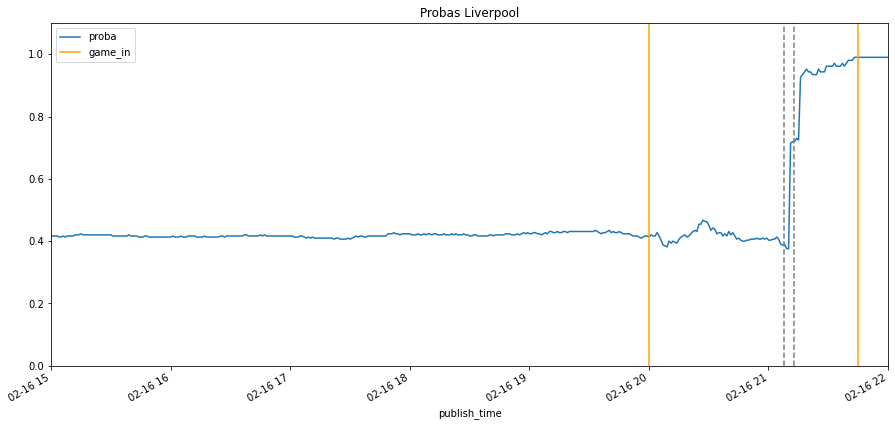

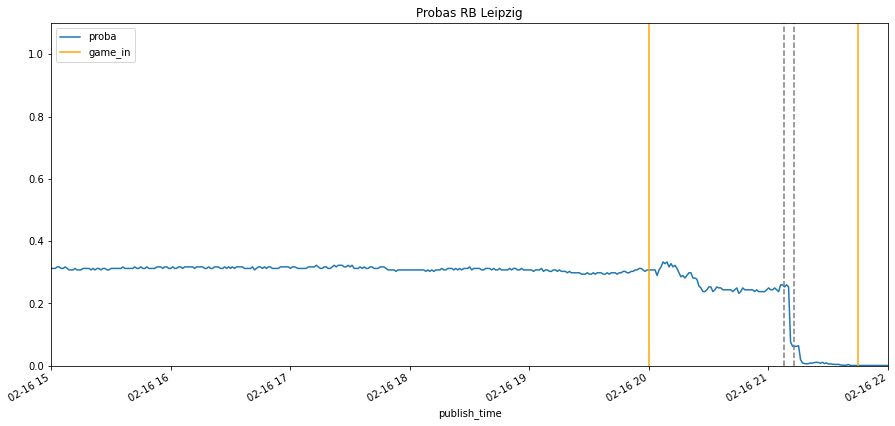

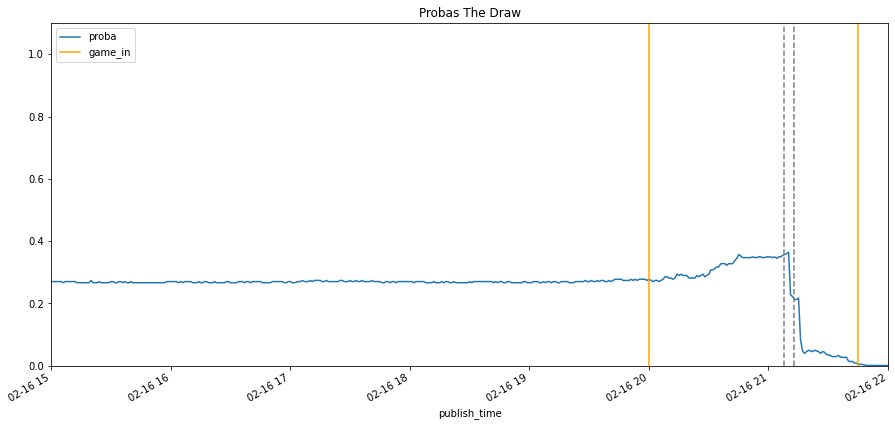

In [35]:
for runner in df_game[df_game["market_type"] == "MATCH_ODDS"]["runner_name"].unique():

    plot_proba_through_time(
        df_game=df_game,
        df_game_filter=(df_game["market_type"] == "MATCH_ODDS") & (df_game["runner_name"] == runner),
        date_time_start_game=start_game_date_time,
        x_lim_hours_start_game=(5, 2),
        y_lim=(0, 1.1),
        title=f"Probas {runner}",
        plot_game_time_limits=True,
        goal_times=goal_times,
        arbitrage_bound=None,
    )

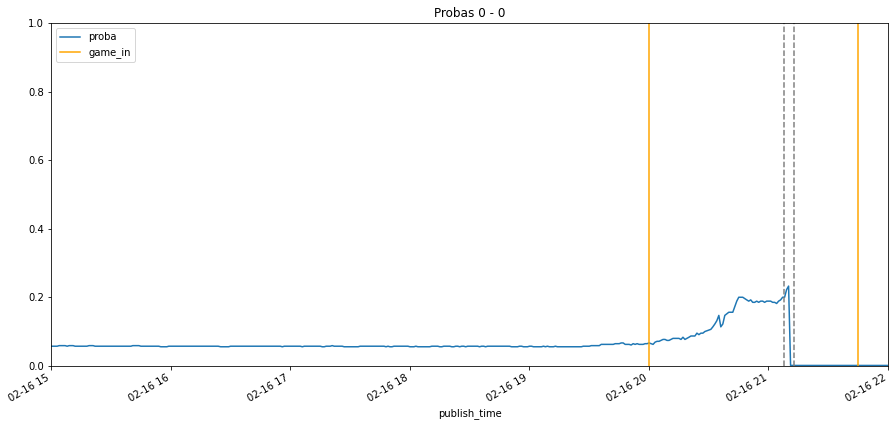

In [38]:
score = "0 - 0"

plot_proba_through_time(
    df_game=df_game,
    df_game_filter=(df_game["market_type"] == "CORRECT_SCORE") & (df_game["runner_name"] == score),
    date_time_start_game=start_game_date_time,
    x_lim_hours_start_game=(5, 2),
    y_lim=(0, 1),
    title=f"Probas {score}",
    plot_game_time_limits=True,
    goal_times=goal_times,
    arbitrage_bound=None,
)

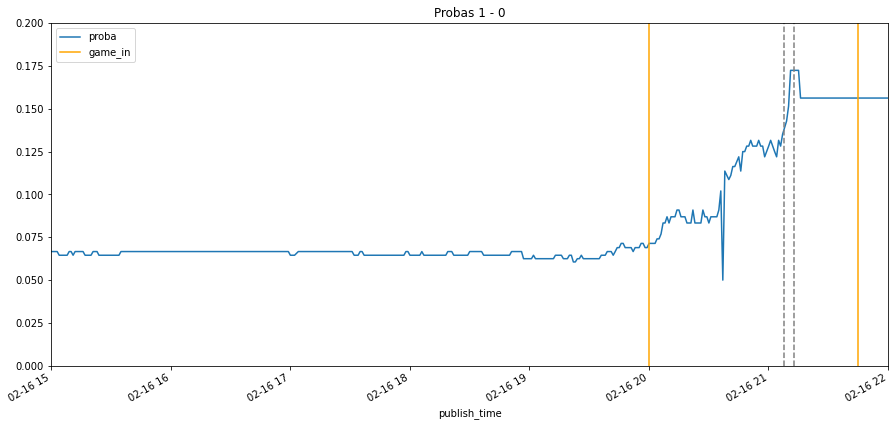

In [39]:
score = "1 - 0"

plot_proba_through_time(
    df_game=df_game,
    df_game_filter=(df_game["market_type"] == "CORRECT_SCORE") & (df_game["runner_name"] == score),
    date_time_start_game=start_game_date_time,
    x_lim_hours_start_game=(5, 2),
    y_lim=(0, .2),
    title=f"Probas {score}",
    plot_game_time_limits=True,
    goal_times=goal_times,
    arbitrage_bound=None,
)

# Within-market arbitrage

In [40]:
df_proba_per_market = df_game.groupby(["market_type", "market_id", "publish_time"])["proba"].sum().reset_index()

In [41]:
market_types_df = (
    df_proba_per_market.groupby("market_type")["market_id"].count().sort_values(ascending=False)
    .reset_index().rename(columns={"market_id": "count"})
)

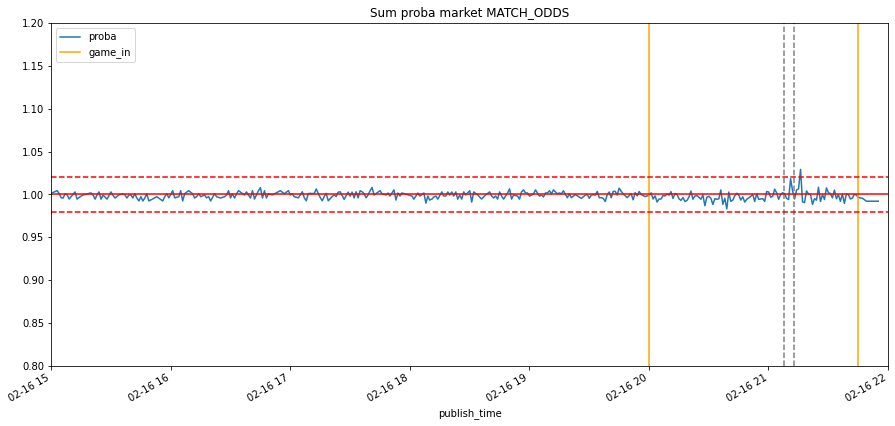

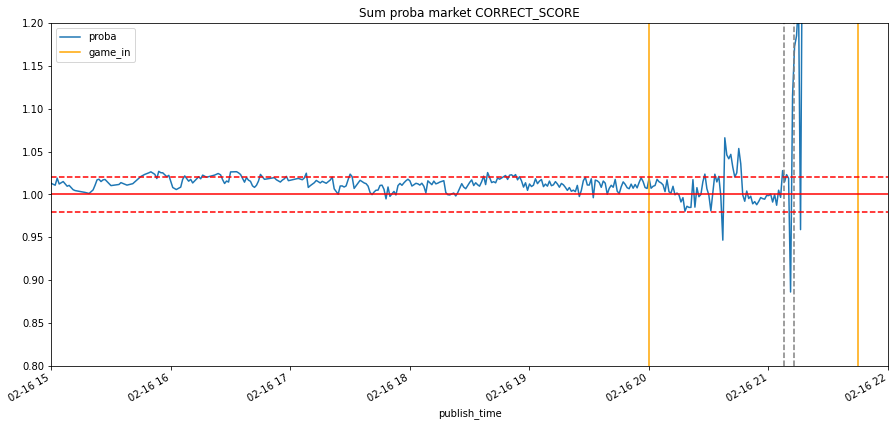

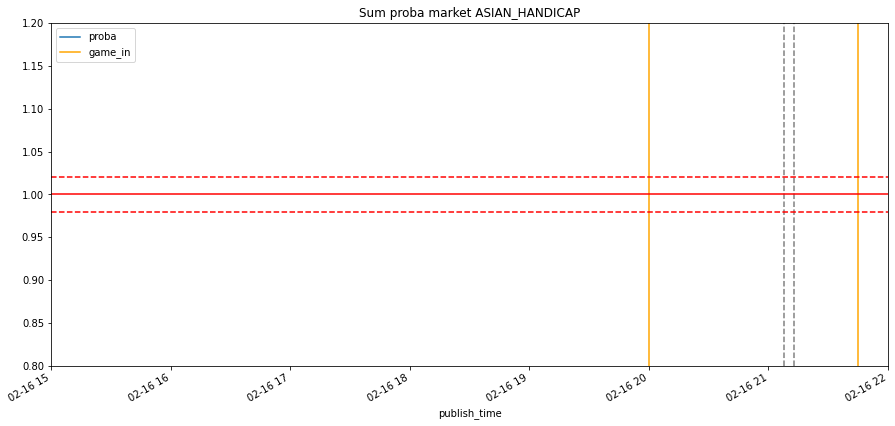

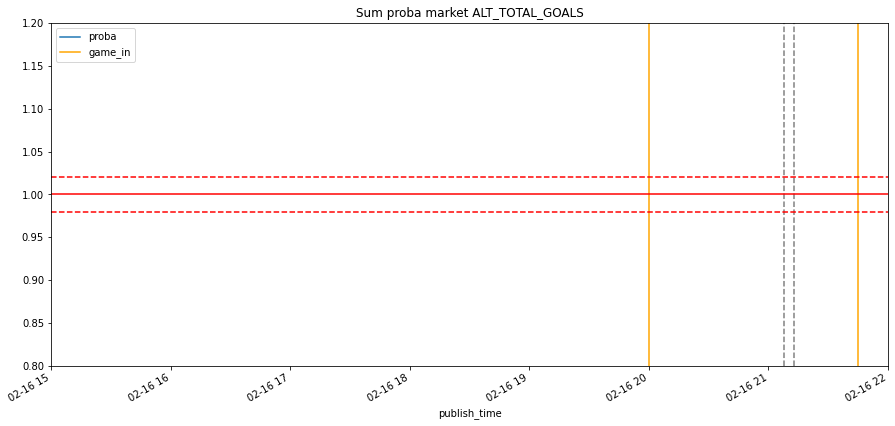

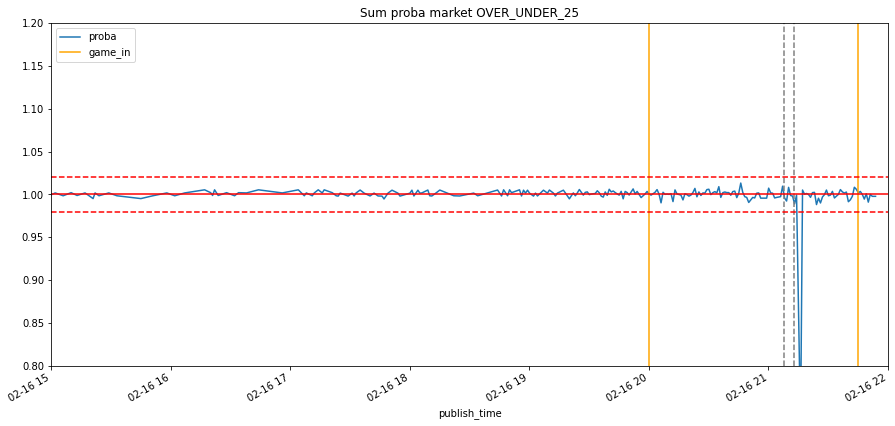

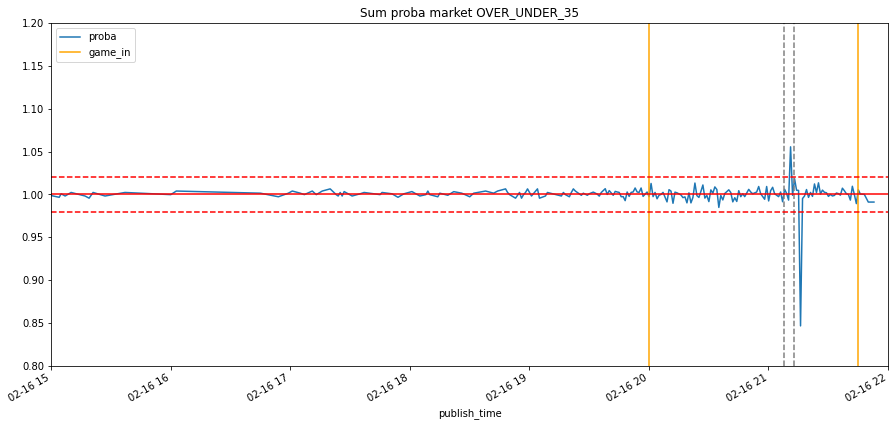

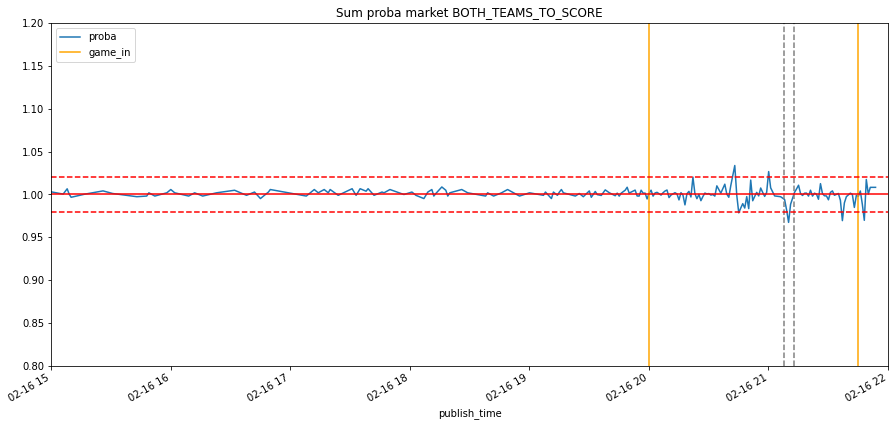

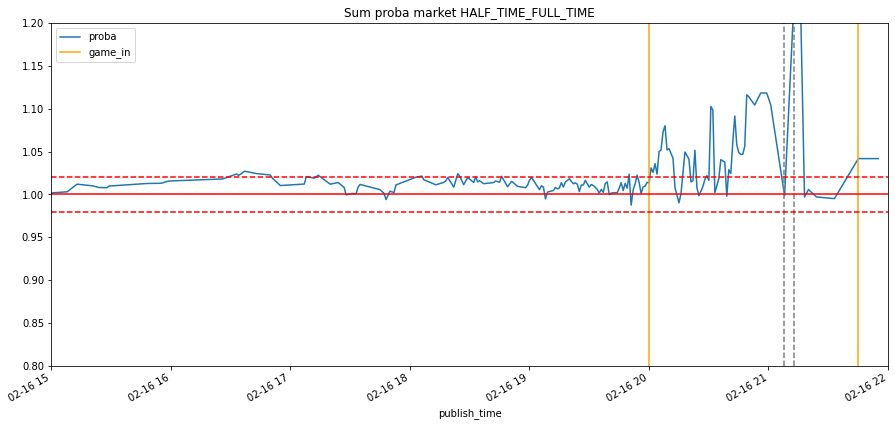

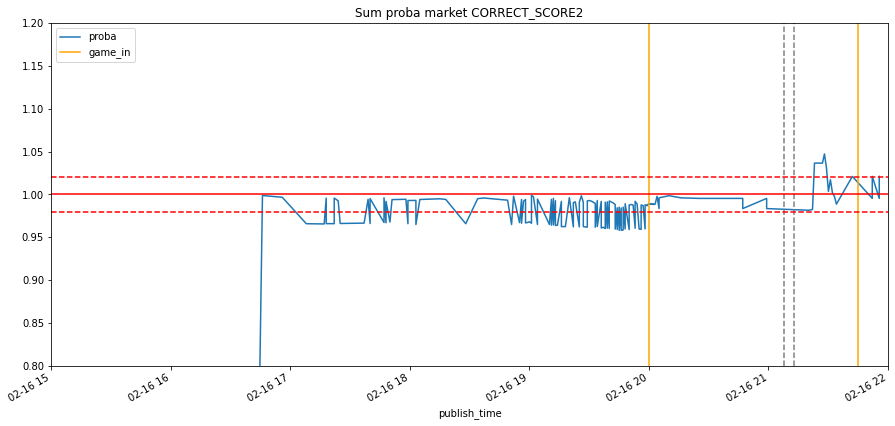

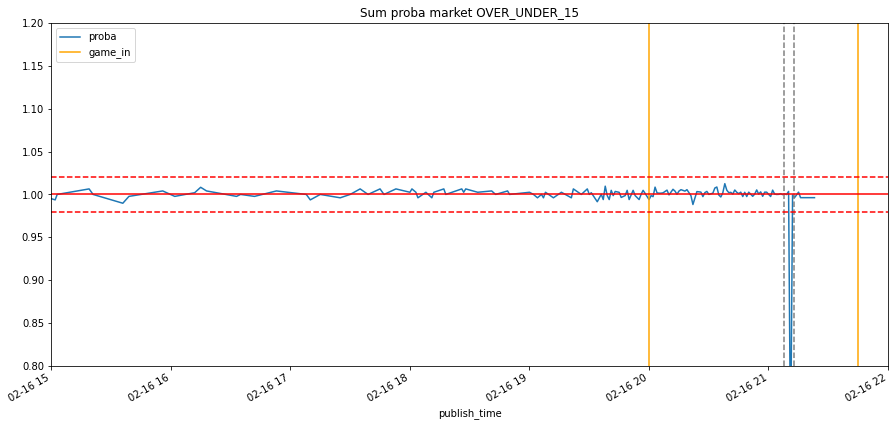

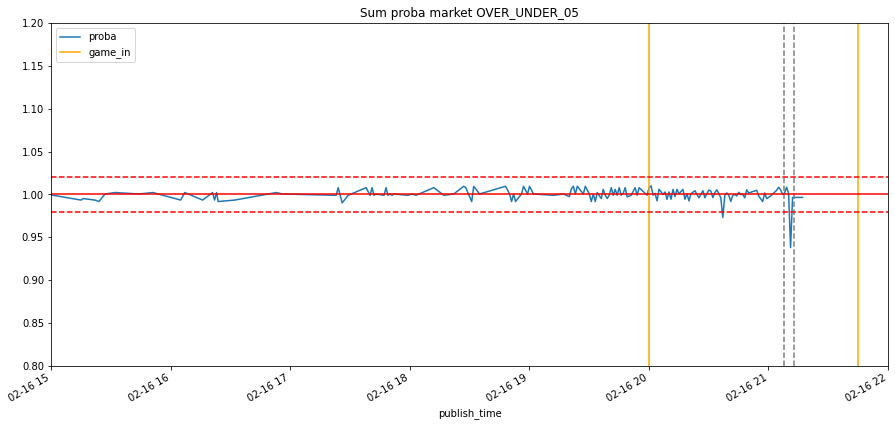

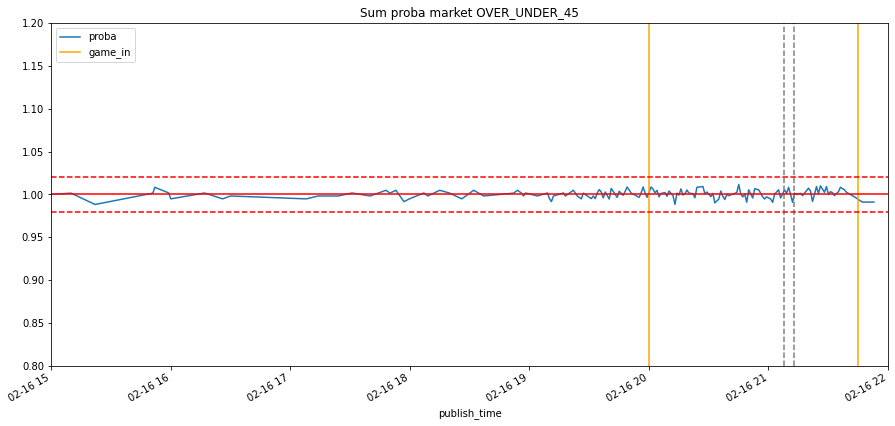

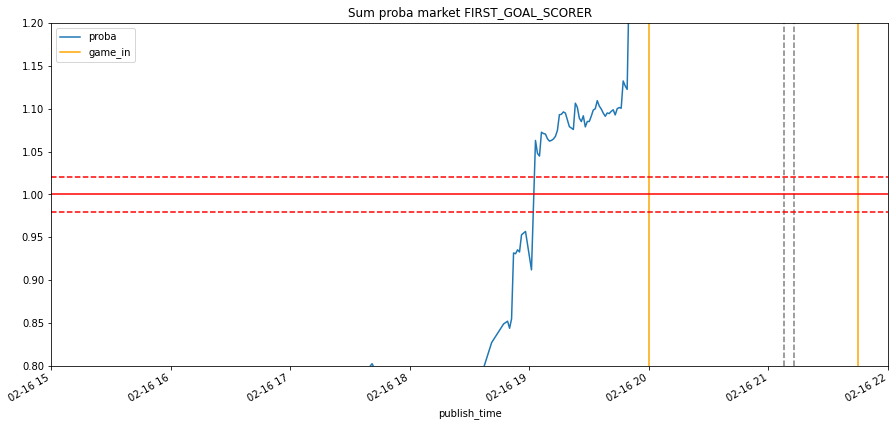

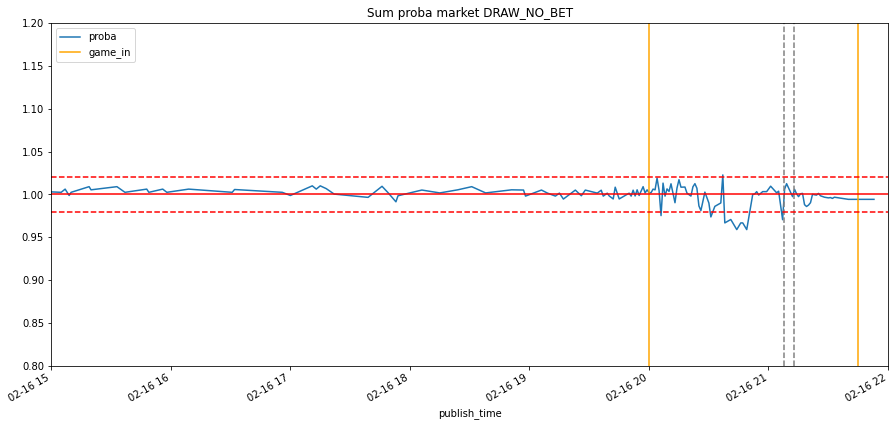

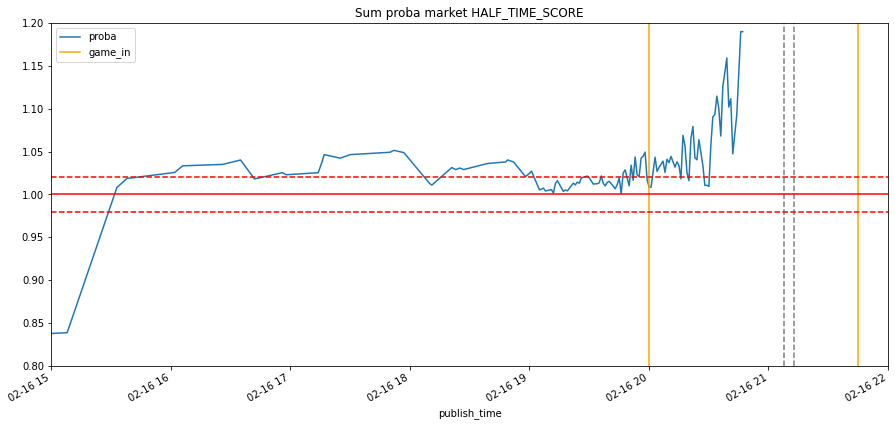

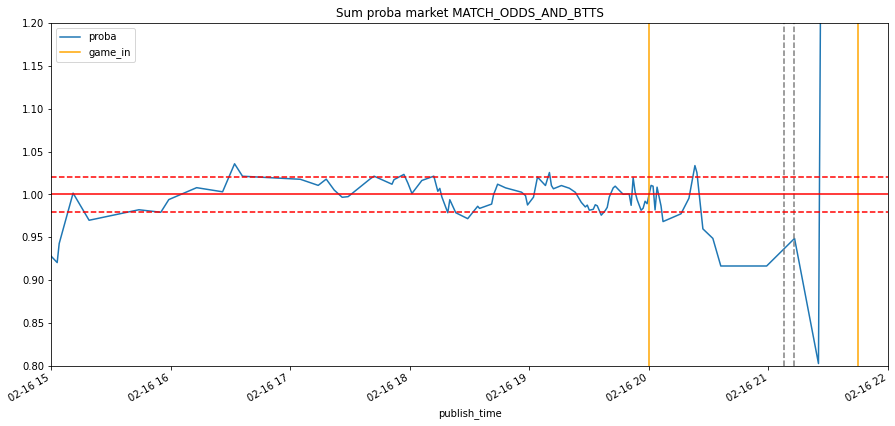

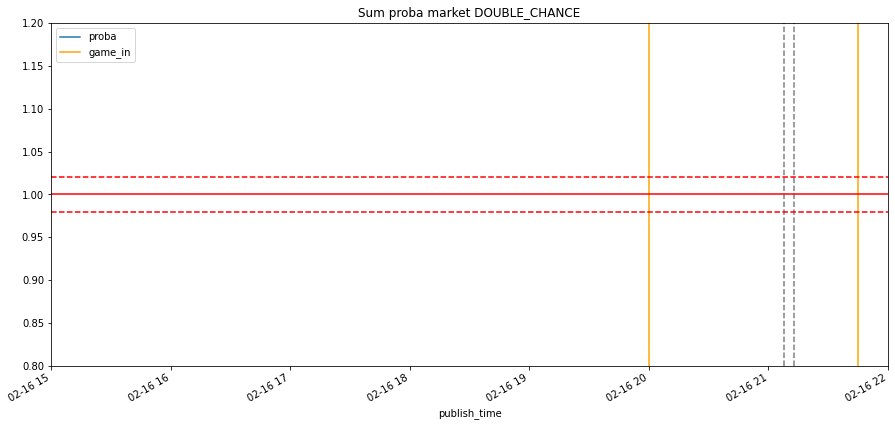

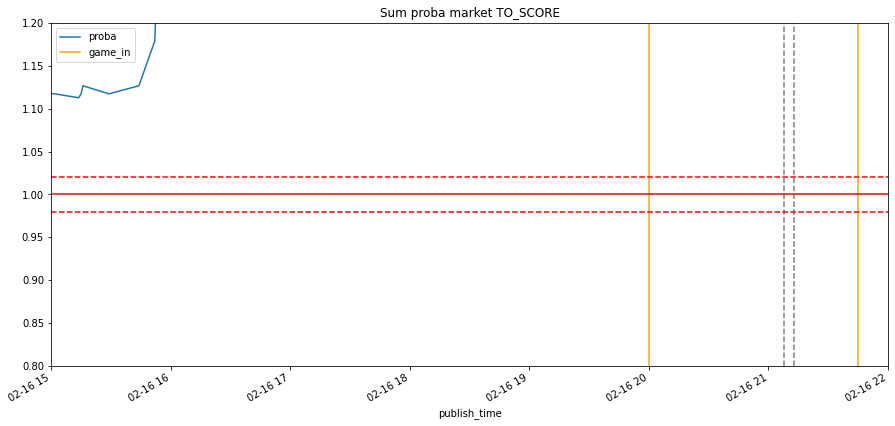

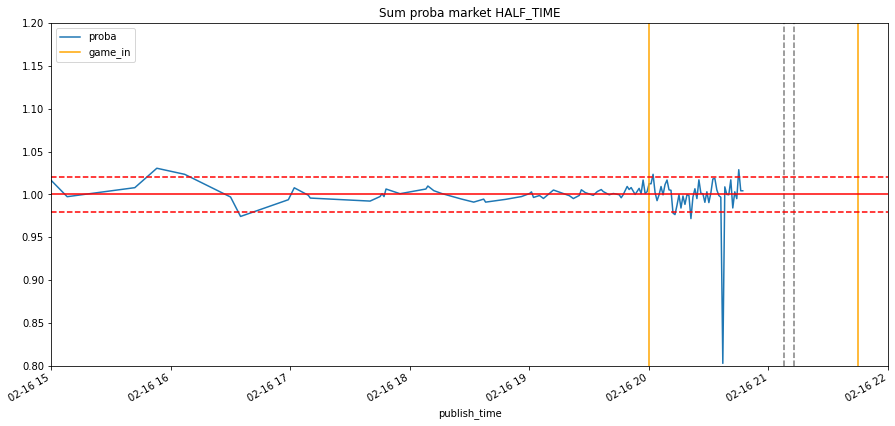

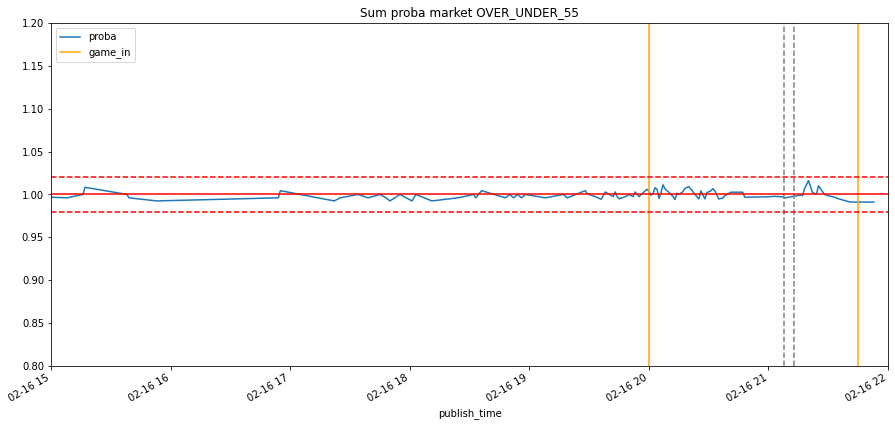

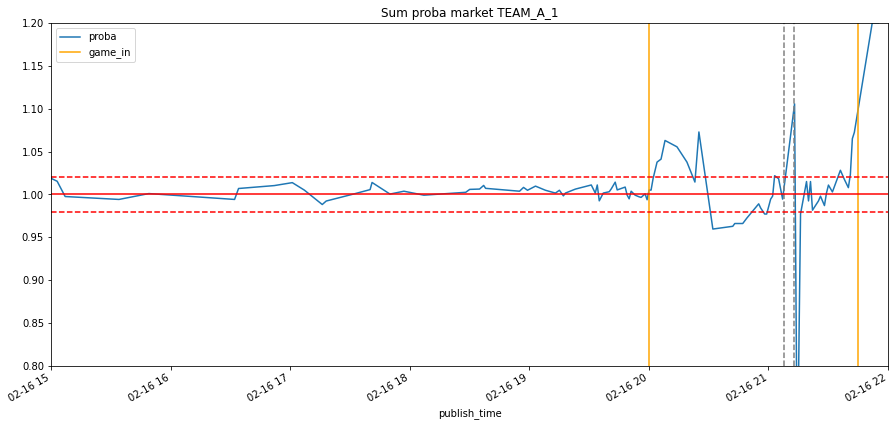

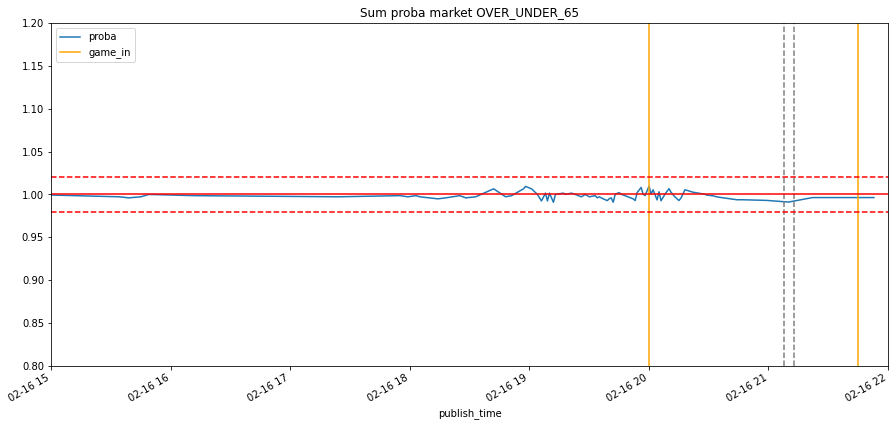

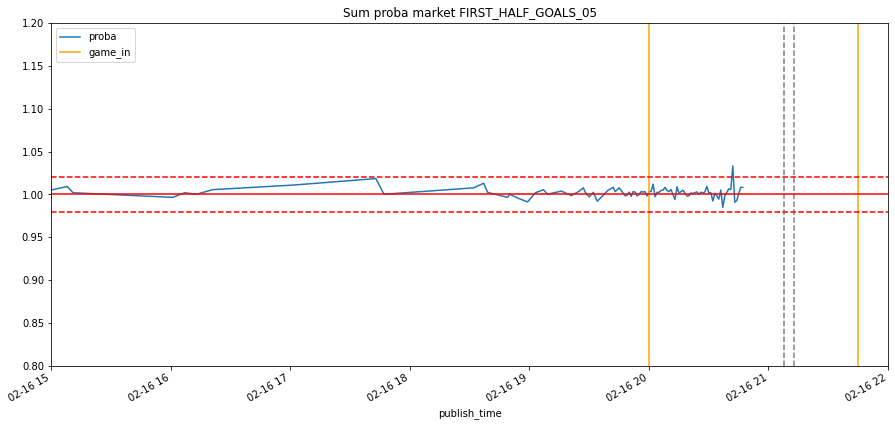

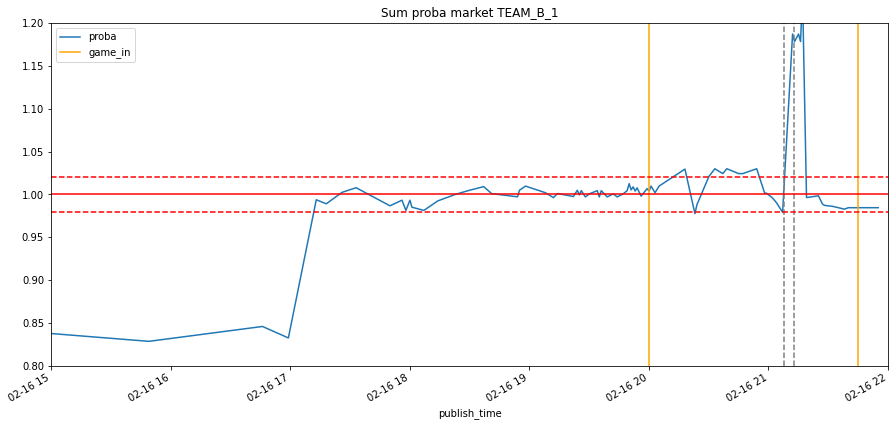

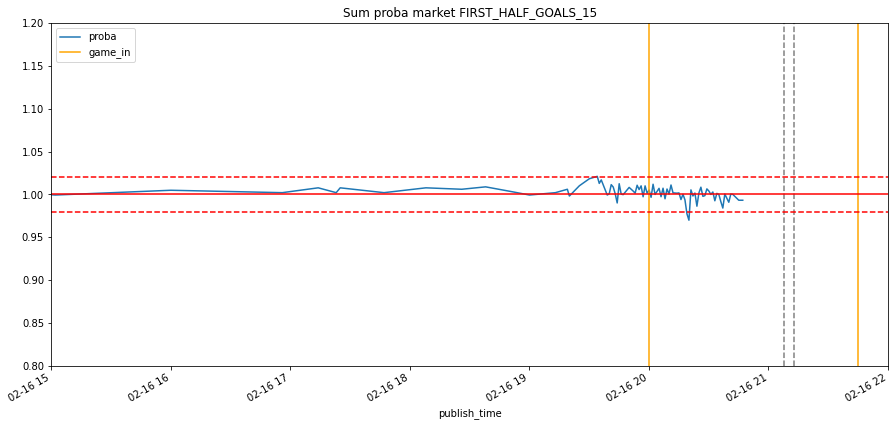

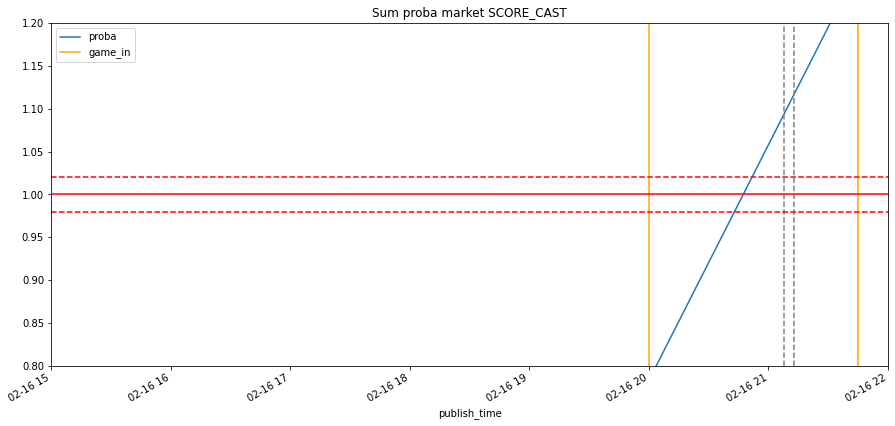

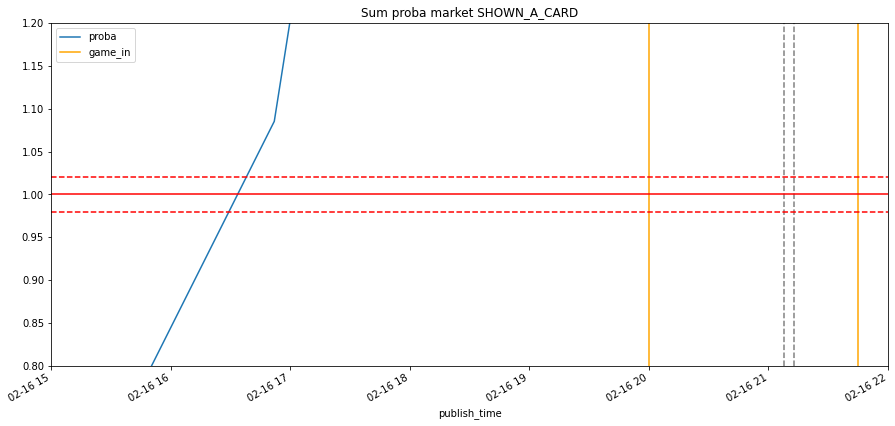

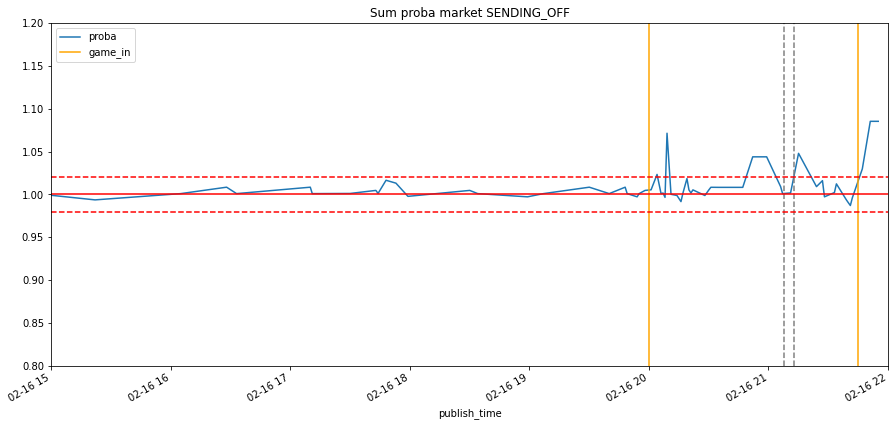

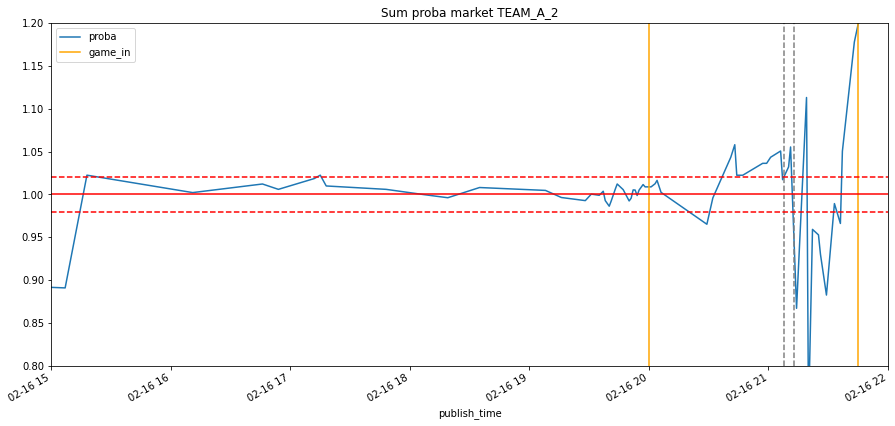

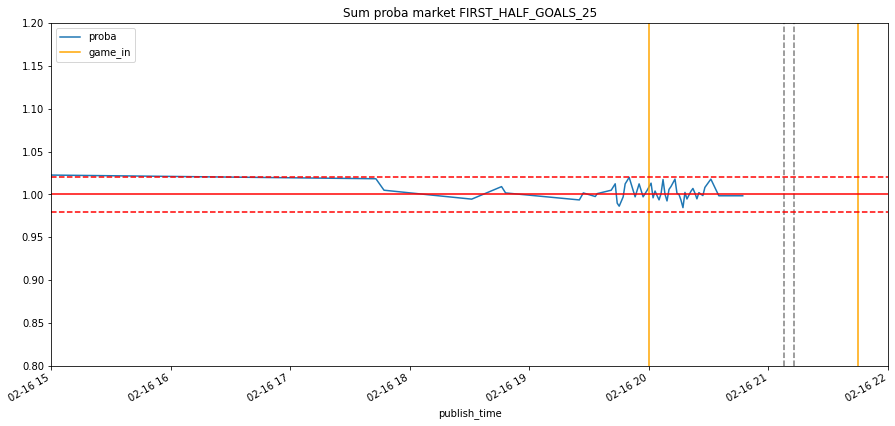

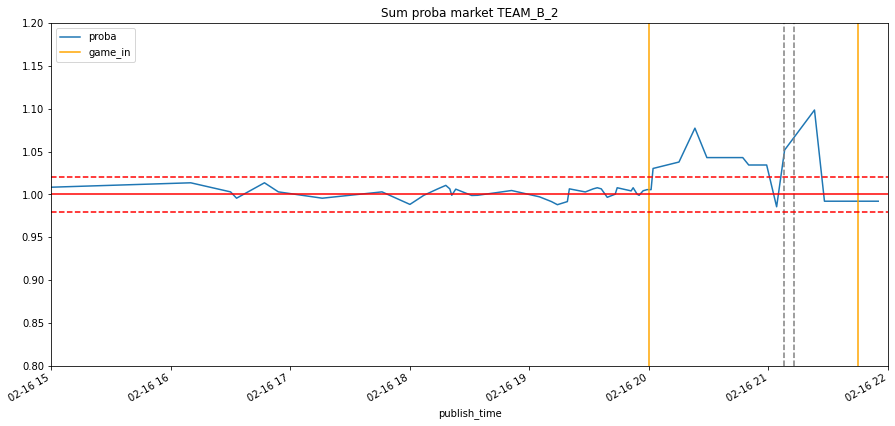

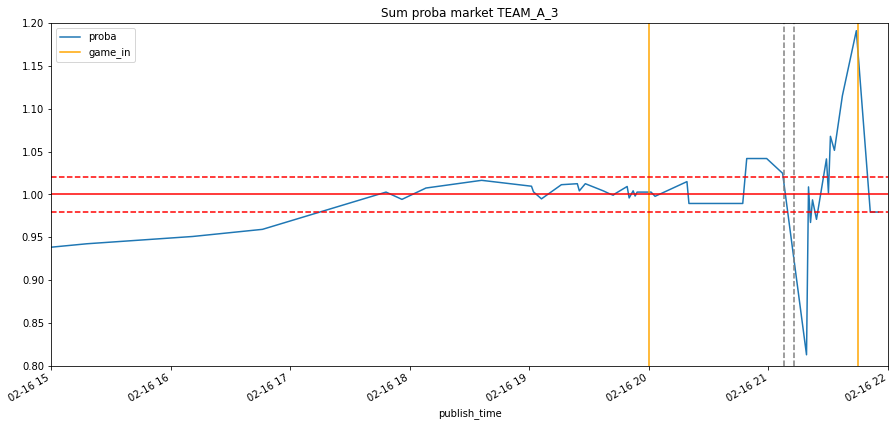

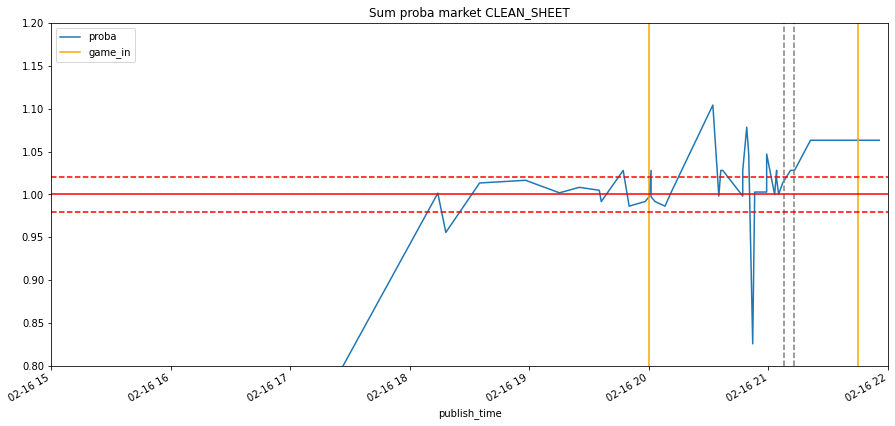

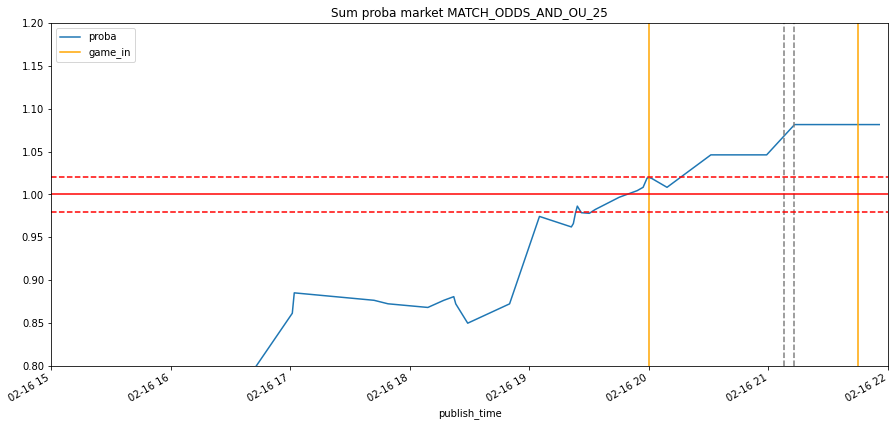

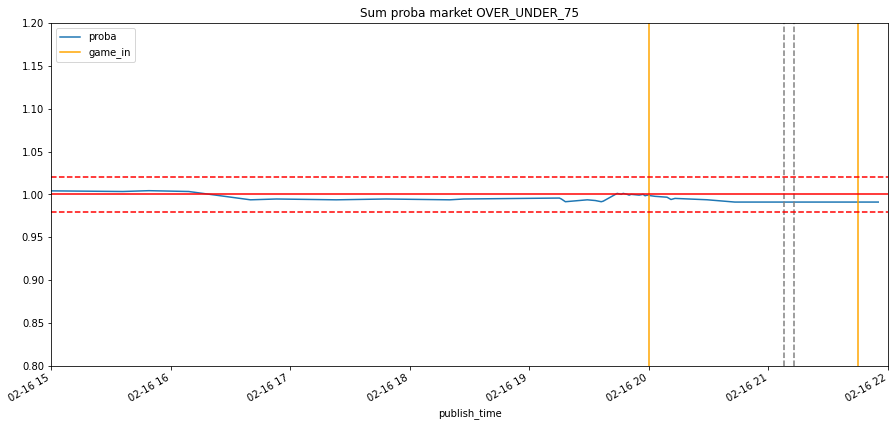

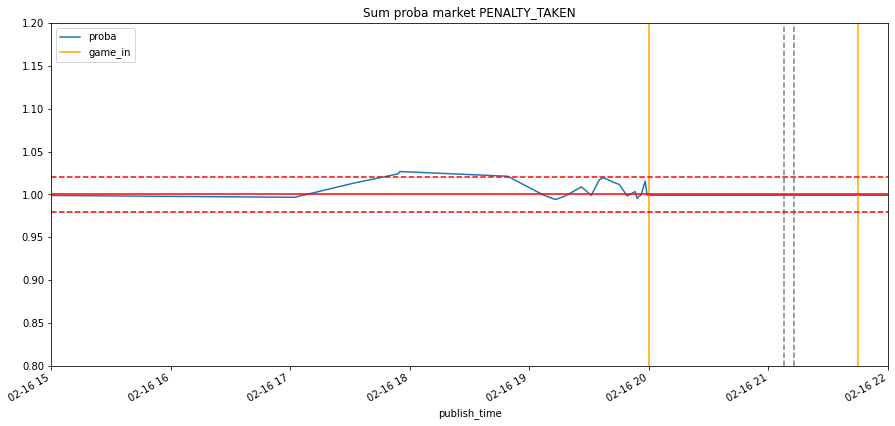

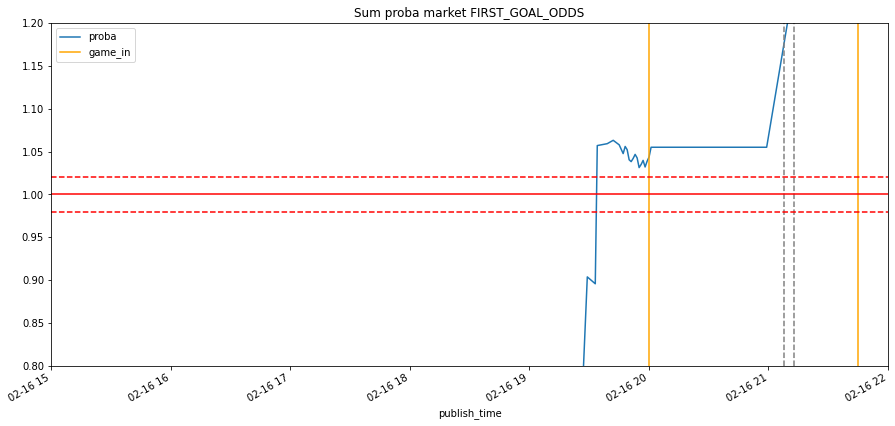

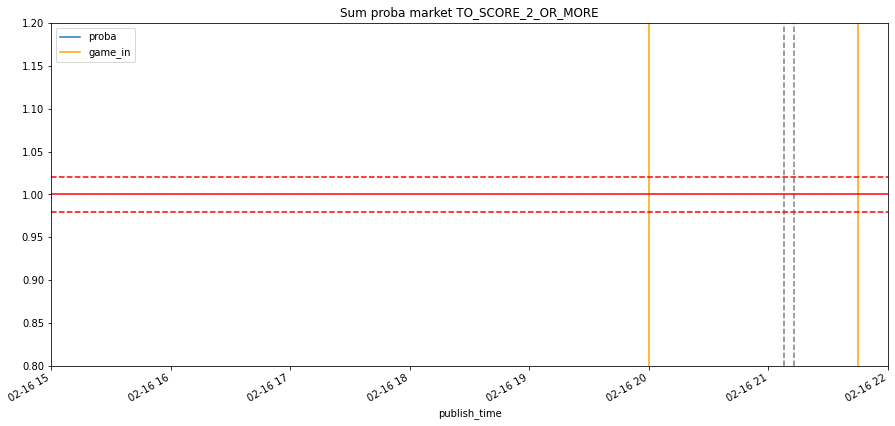

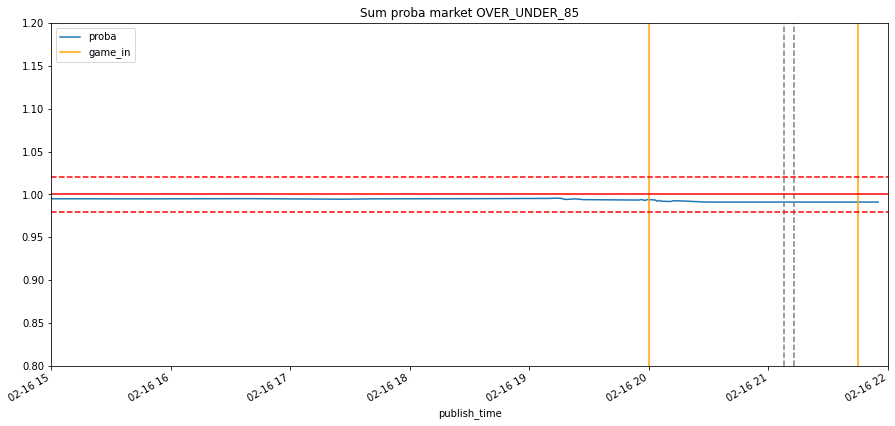

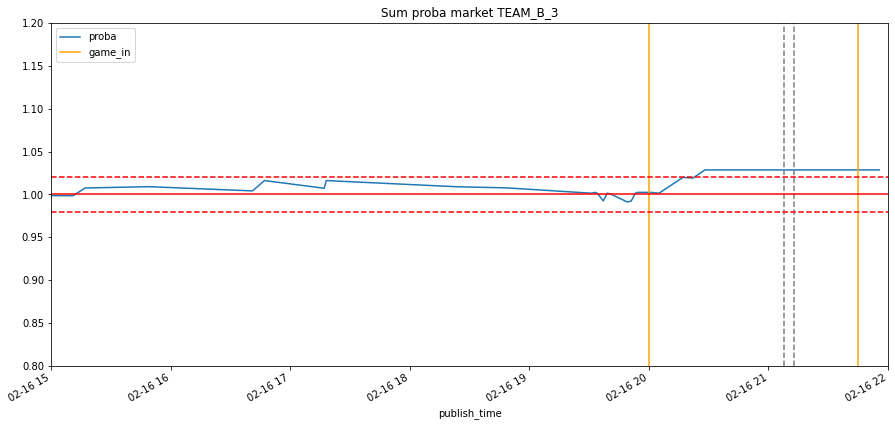

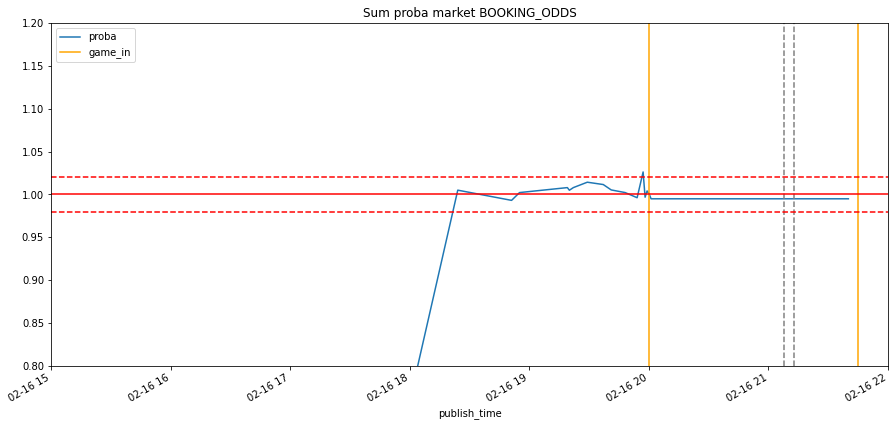

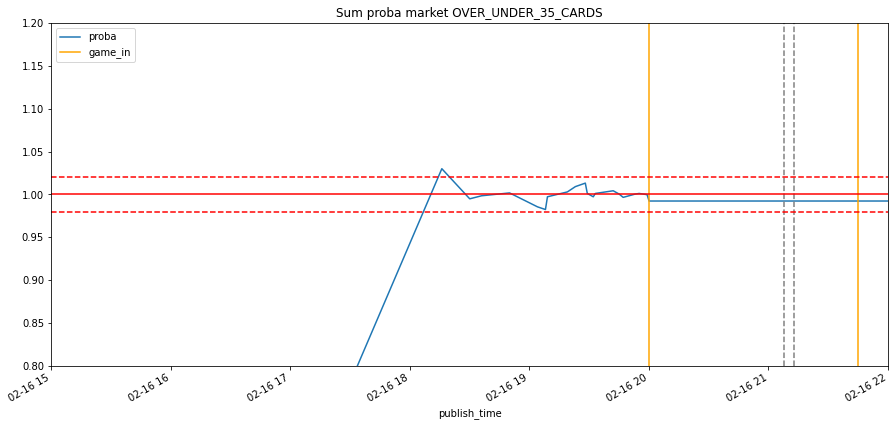

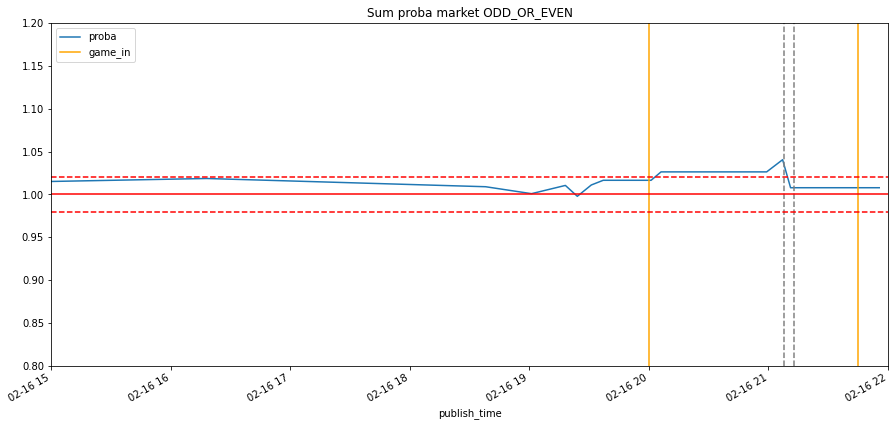

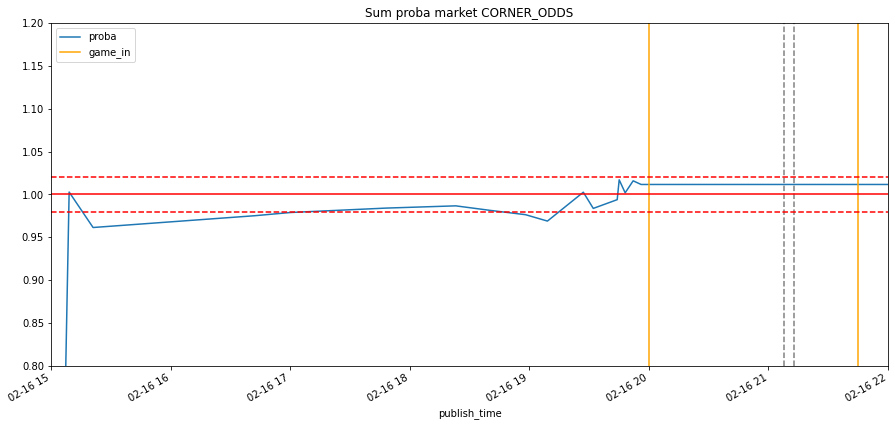

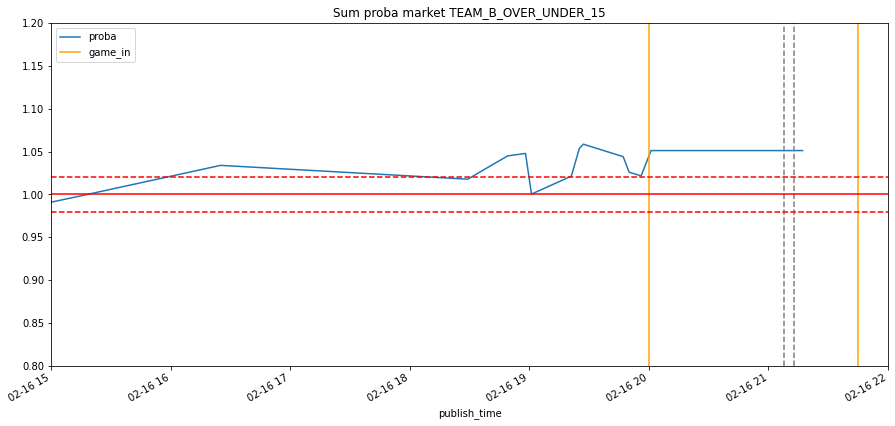

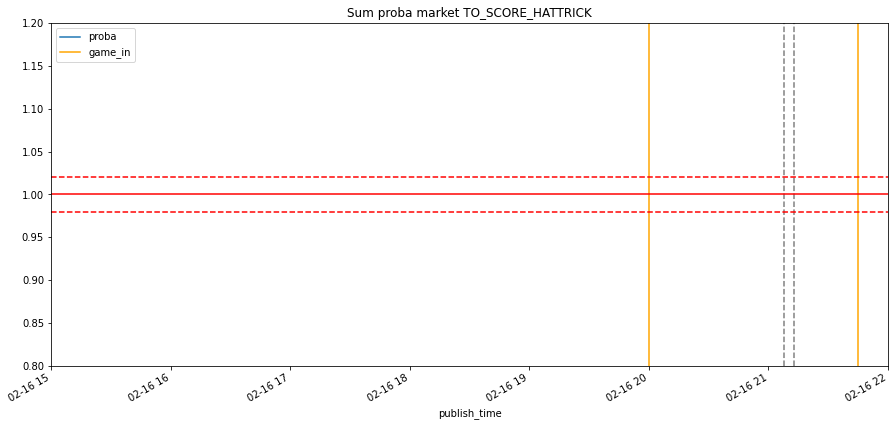

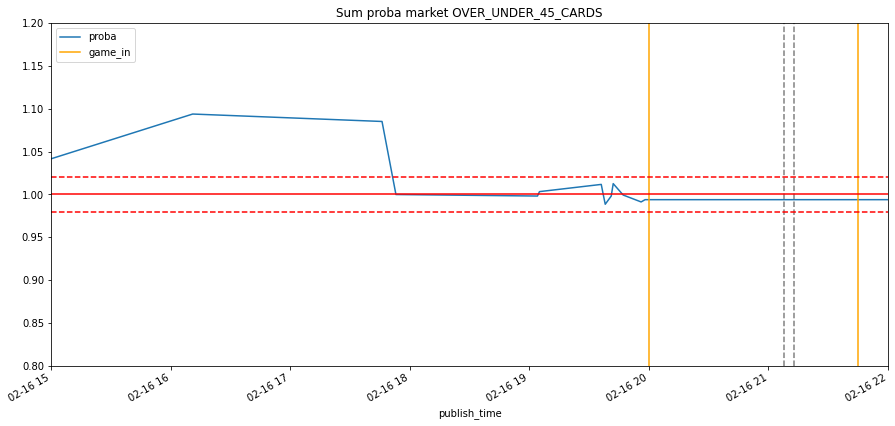

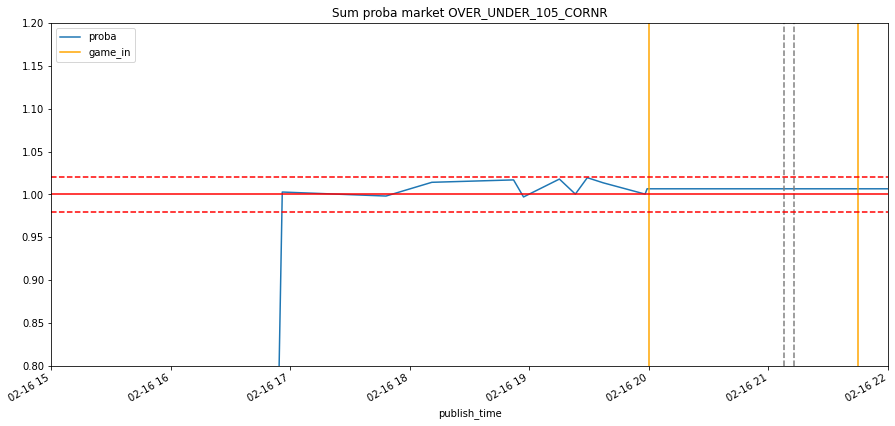

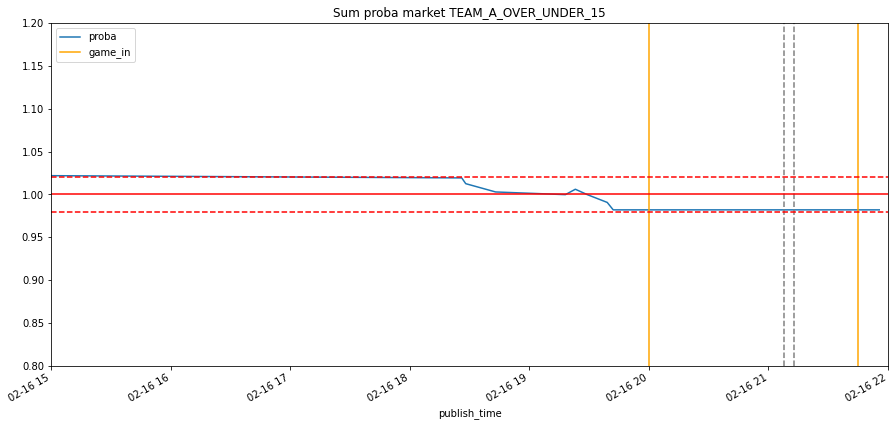

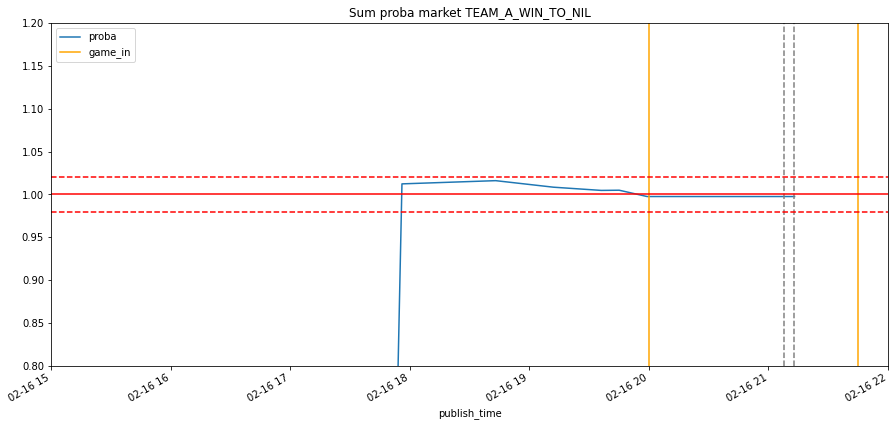

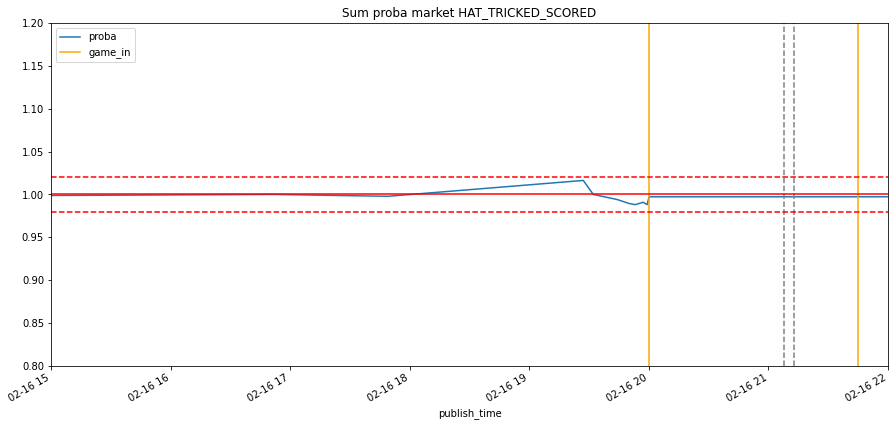

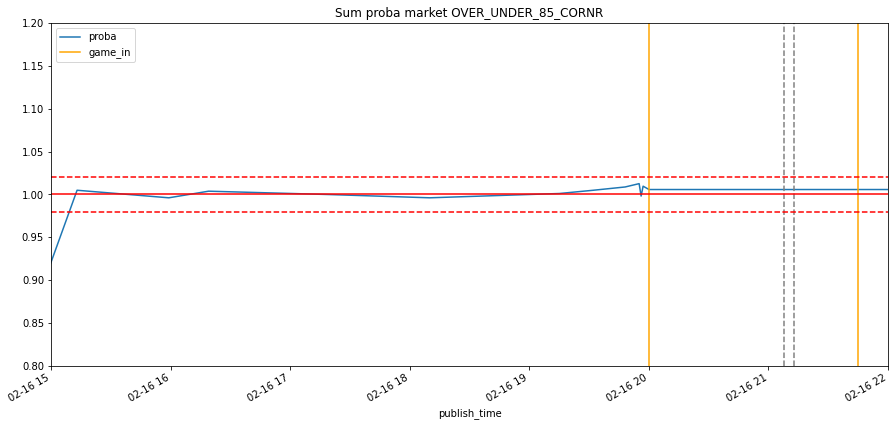

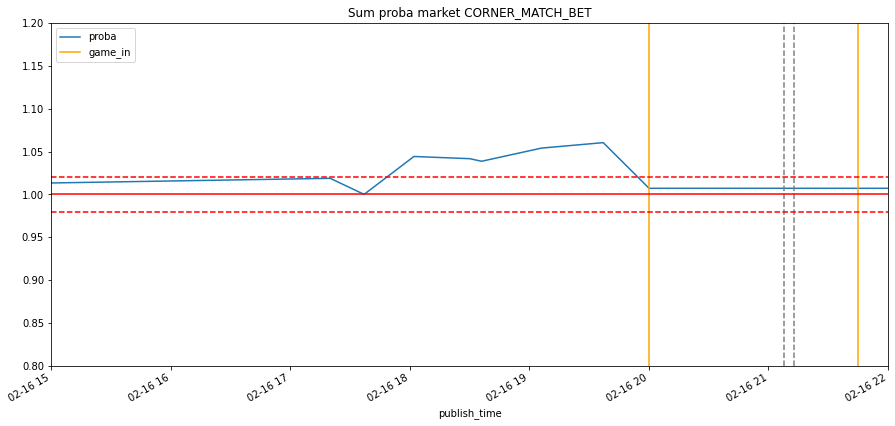

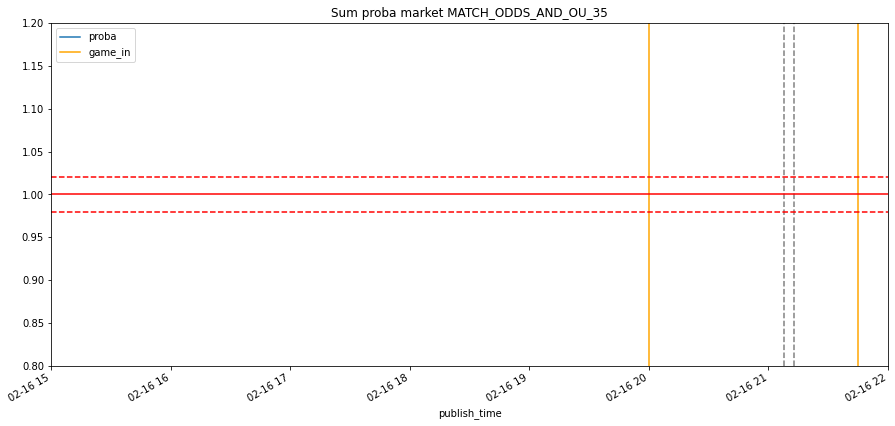

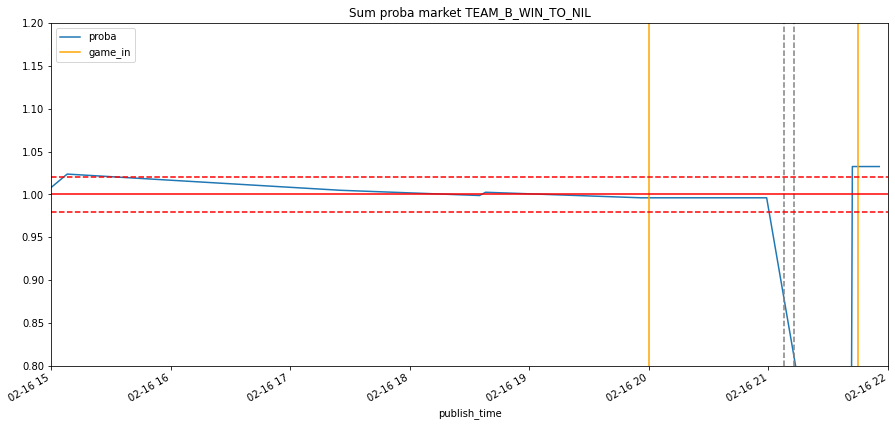

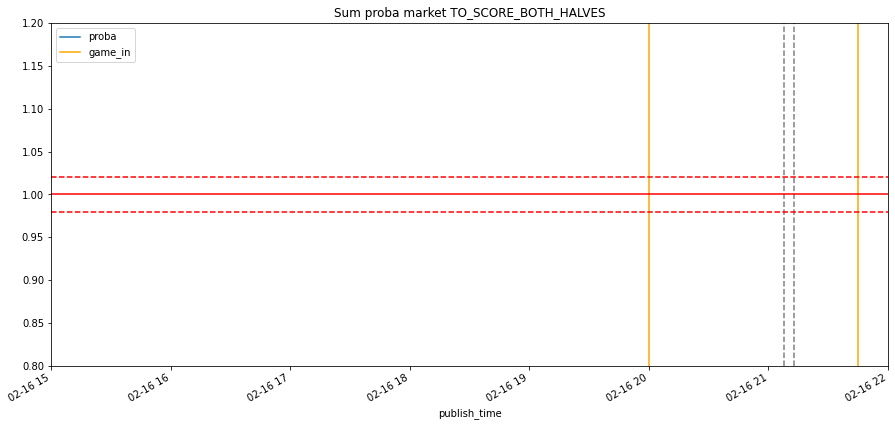

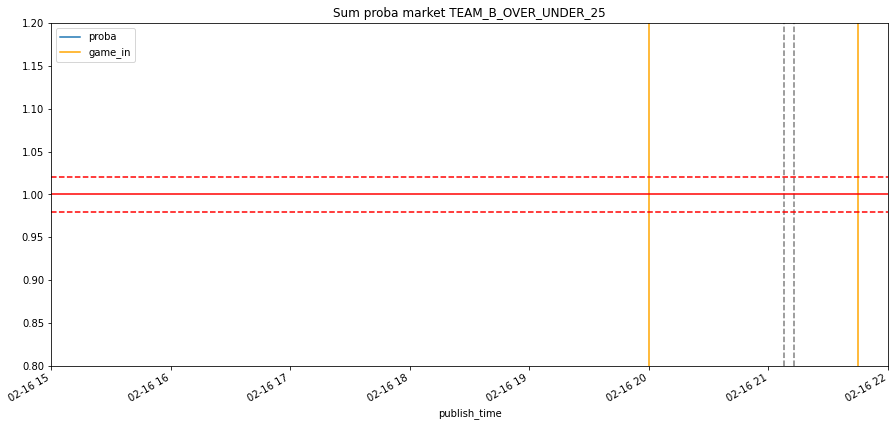

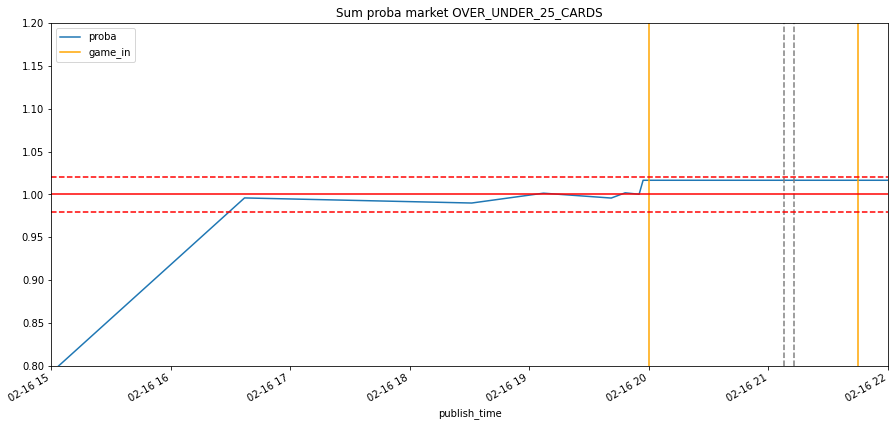

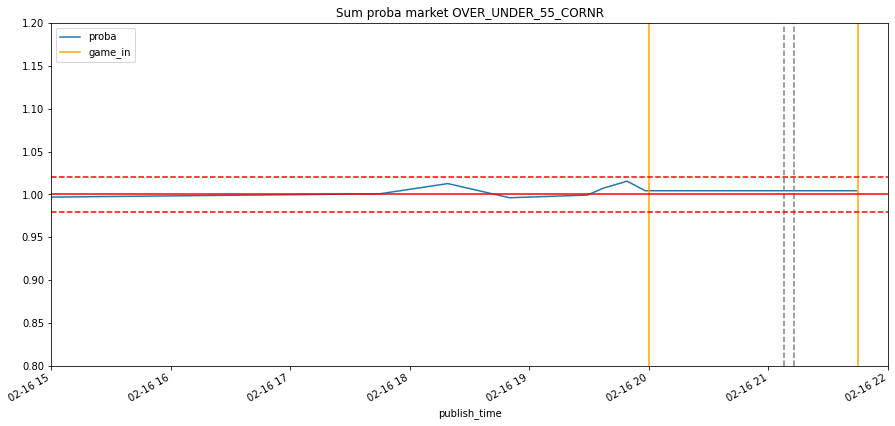

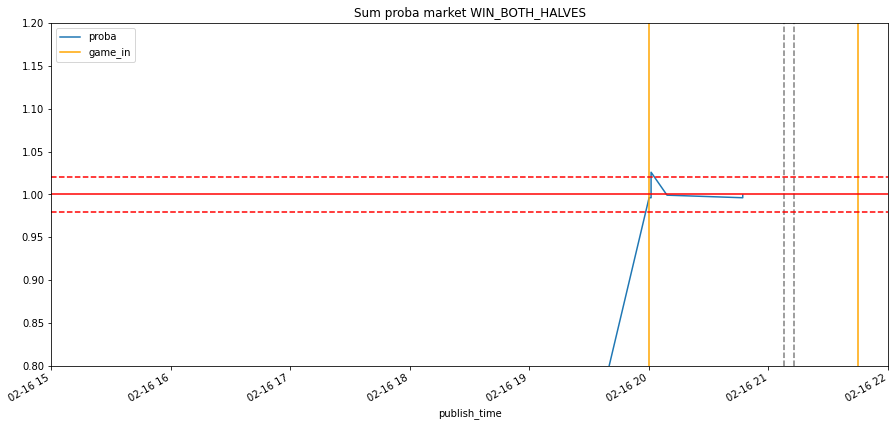

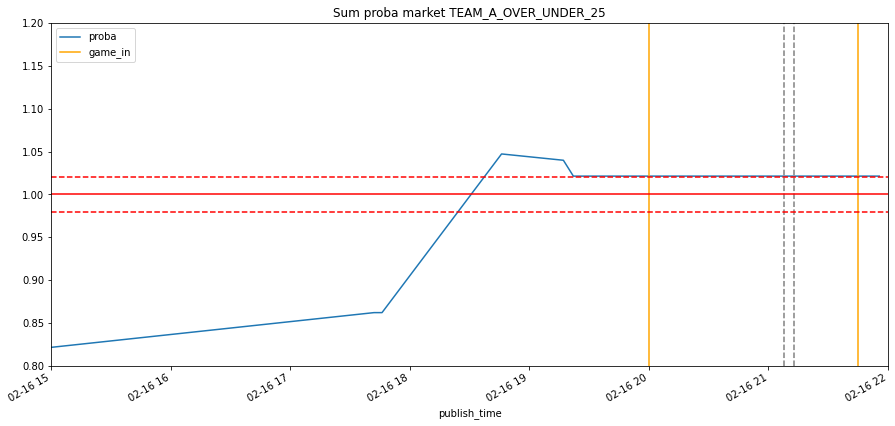

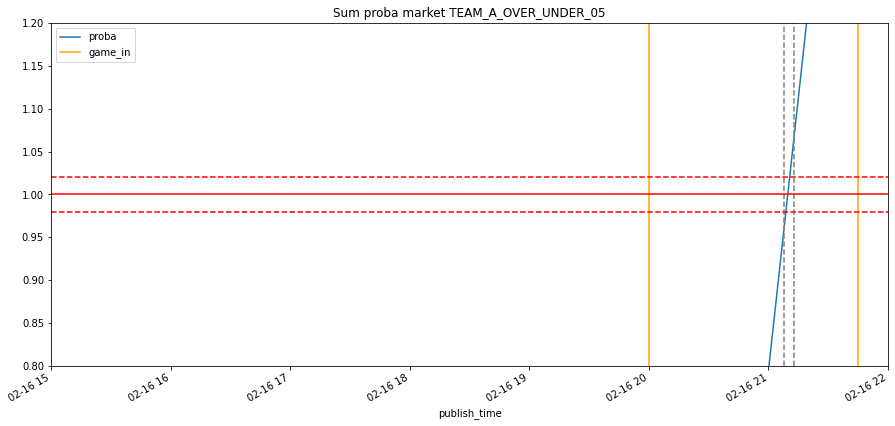

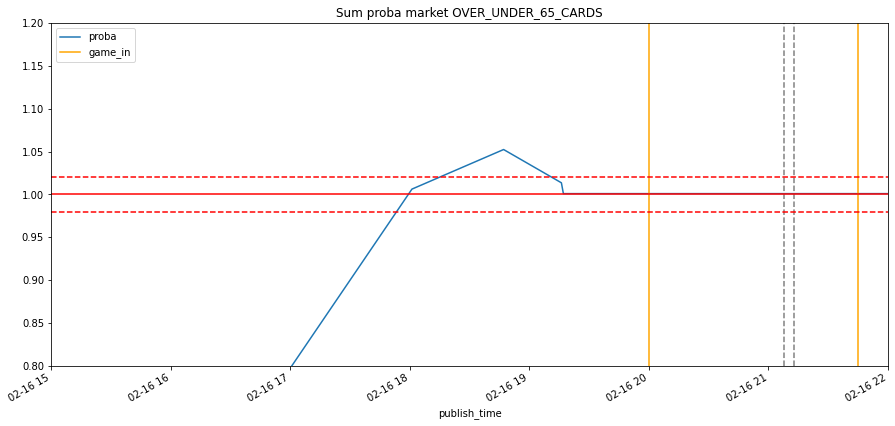

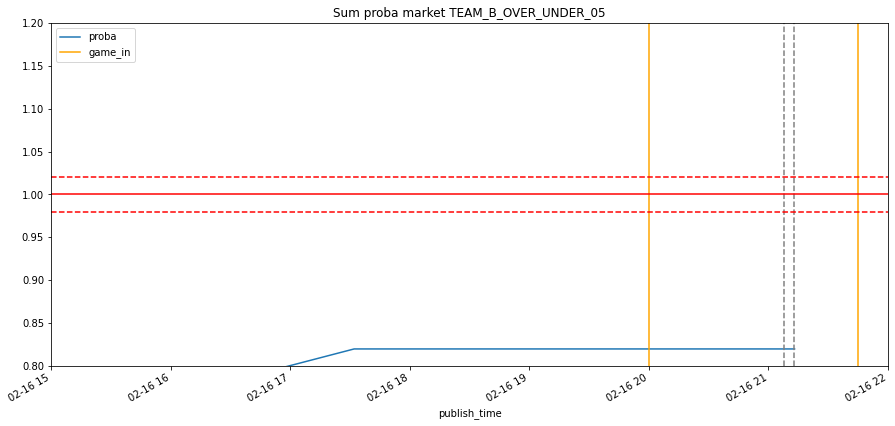

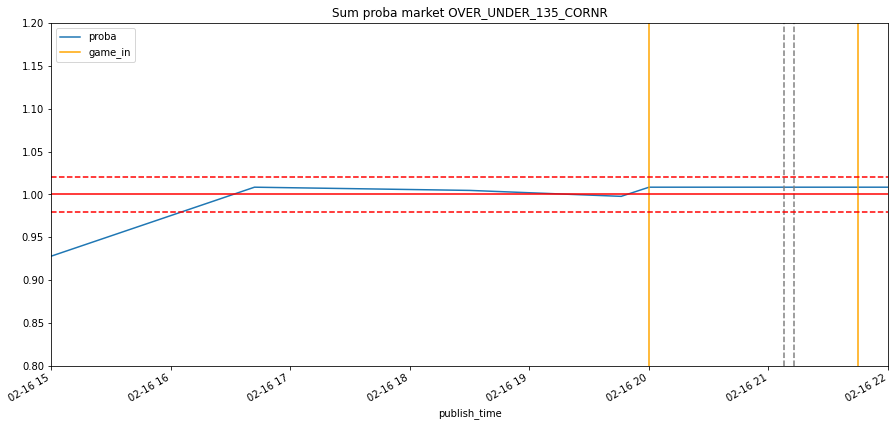

In [42]:
for market_type in market_types_df["market_type"]:
    plot_proba_through_time(
        df_game=df_proba_per_market,
        df_game_filter=(df_proba_per_market["market_type"] == market_type),
        date_time_start_game=start_game_date_time,
        x_lim_hours_start_game=(5, 2),
        y_lim=(.8, 1.2),
        title=f"Sum proba market {market_type}",
        plot_game_time_limits=True,
        goal_times=goal_times,
        arbitrage_bound=.02,
    )

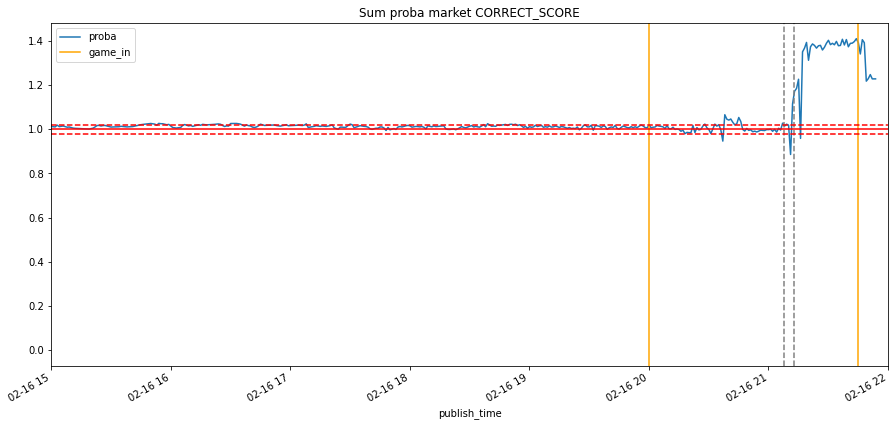

In [19]:
market_type = "CORRECT_SCORE"

plot_proba_through_time(
    df_game=df_proba_per_market,
    df_game_filter=(df_proba_per_market["market_type"] == market_type),
    date_time_start_game=start_game_date_time,
    x_lim_hours_start_game=(5, 2),
    y_lim=None,
    title=f"Sum proba market {market_type}",
    plot_game_time_limits=True,
    goal_times=goal_times,
    arbitrage_bound=.02,
)

# Accross markets arbitrage

## 1. Arbitrage under x goal vs score

In [43]:
def get_all_scores_under_i_goals(nb_goals_max):
    return [f"{i} - {k}" for i in range(0, nb_goals_max+1) for k in range(0, nb_goals_max-i+1)]

In [44]:
df_game[df_game["market_type"].str.contains("OVER_UNDER_")]["market_type"].unique()

array(['OVER_UNDER_05', 'OVER_UNDER_105_CORNR', 'OVER_UNDER_135_CORNR',
       'OVER_UNDER_15', 'OVER_UNDER_25', 'OVER_UNDER_25_CARDS',
       'OVER_UNDER_35', 'OVER_UNDER_35_CARDS', 'OVER_UNDER_45',
       'OVER_UNDER_45_CARDS', 'OVER_UNDER_55', 'OVER_UNDER_55_CORNR',
       'OVER_UNDER_65', 'OVER_UNDER_65_CARDS', 'OVER_UNDER_75',
       'OVER_UNDER_85', 'OVER_UNDER_85_CORNR', 'TEAM_A_OVER_UNDER_05',
       'TEAM_A_OVER_UNDER_15', 'TEAM_A_OVER_UNDER_25',
       'TEAM_B_OVER_UNDER_05', 'TEAM_B_OVER_UNDER_15',
       'TEAM_B_OVER_UNDER_25'], dtype=object)

In [45]:
df_game.loc[df_game["market_type"]=="OVER_UNDER_05", "runner_name"].unique()

array(['Over 0.5 Goals', 'Under 0.5 Goals'], dtype=object)

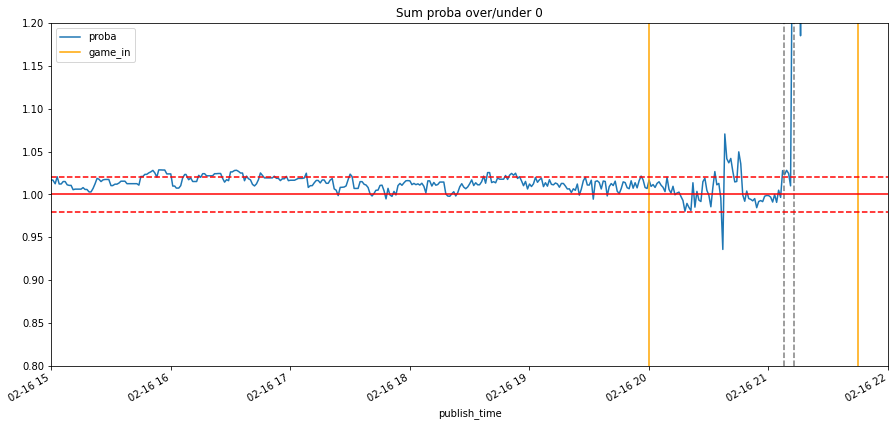

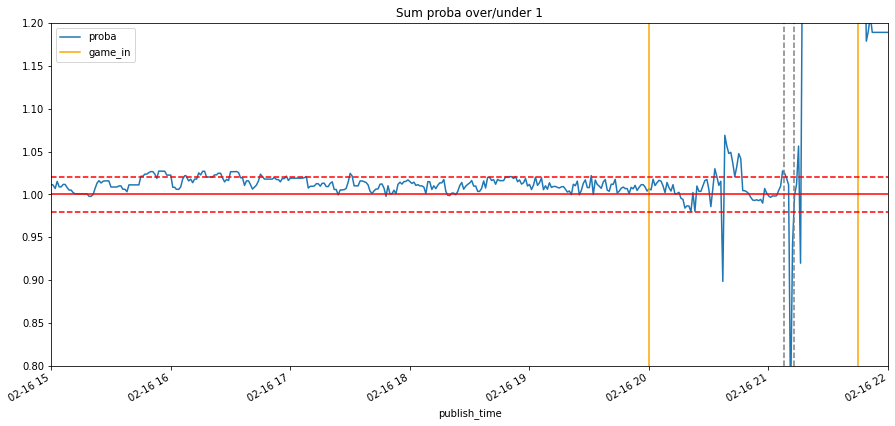

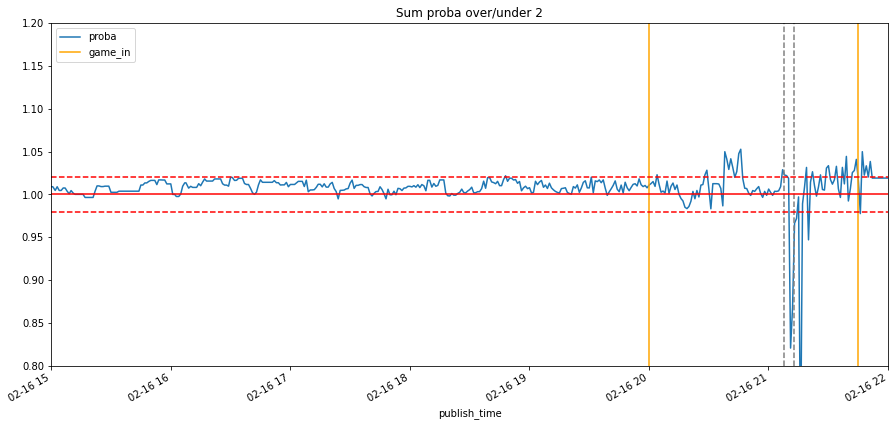

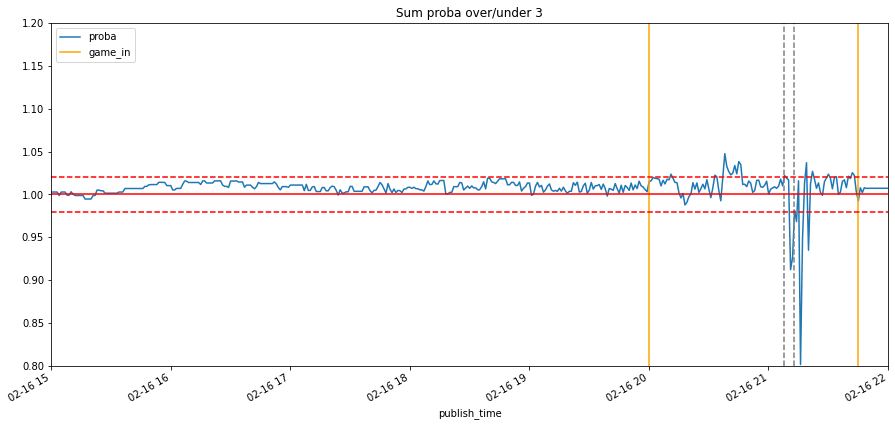

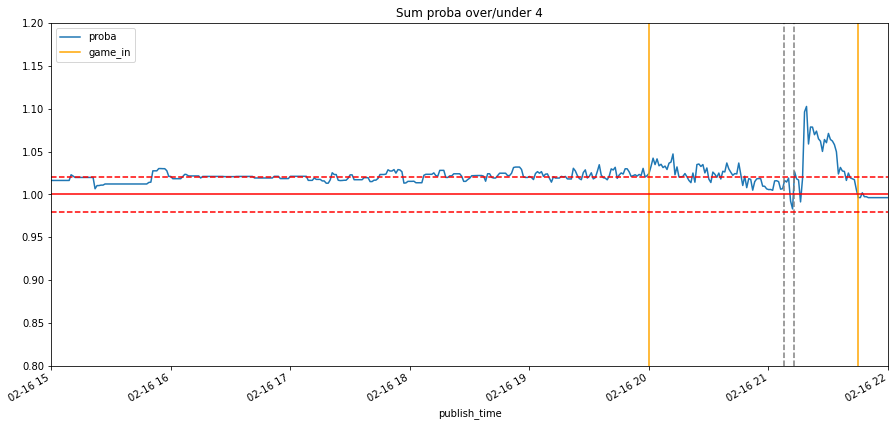

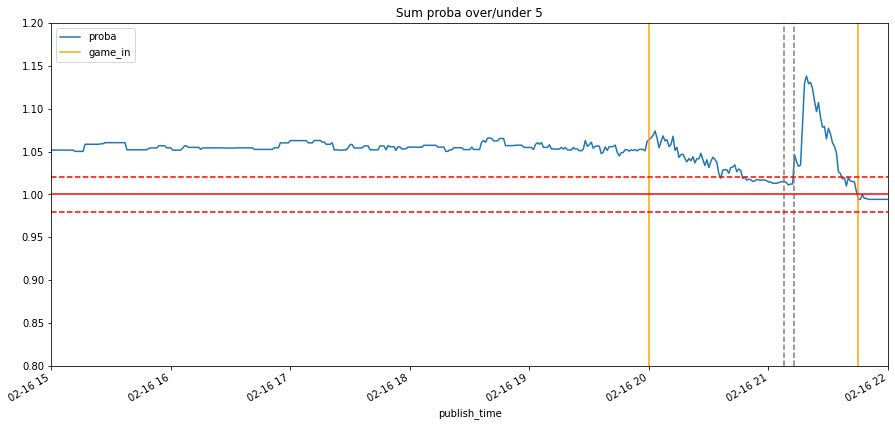

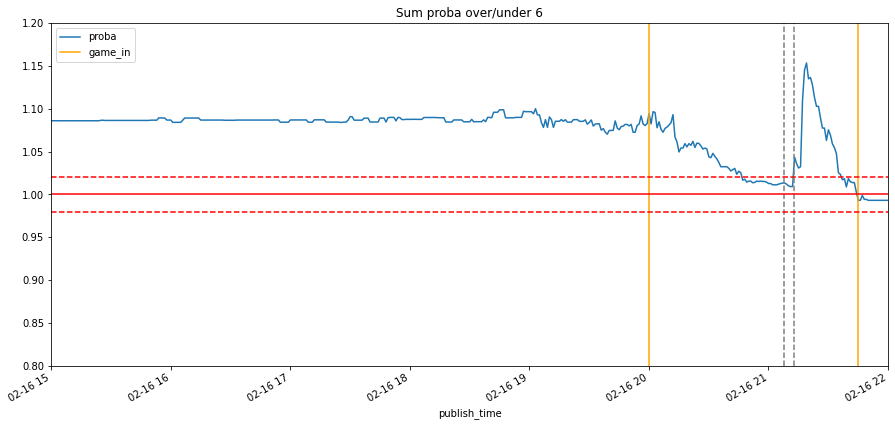

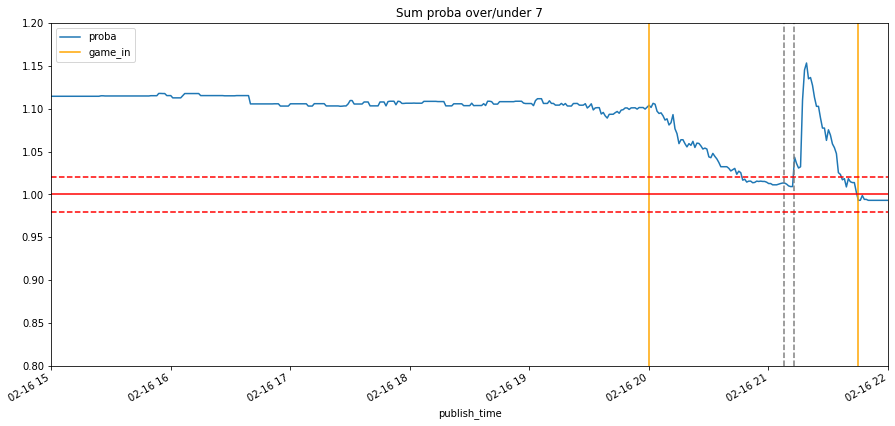

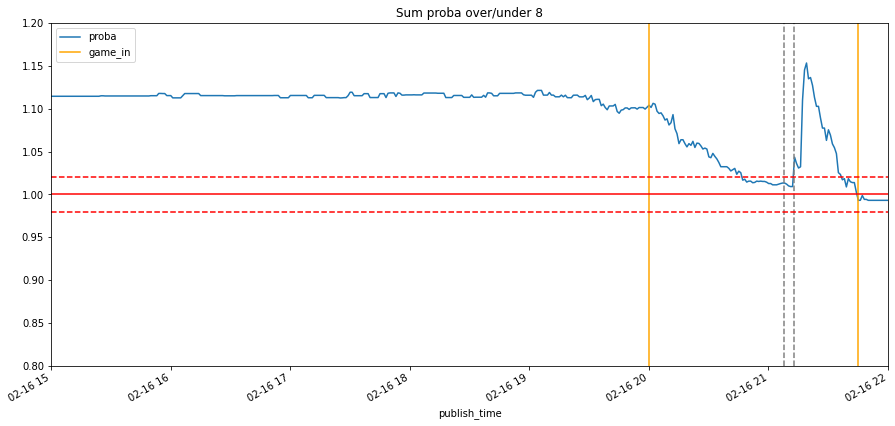

In [46]:
for i in range(0, 9):
    df_game["tmp_arbitrage_group"] = np.where(
        ((df_game["market_type"] == f"OVER_UNDER_{i}5") & (df_game["runner_name"] == f"Under {i}.5 Goals")) |
        ((df_game["market_type"] == "CORRECT_SCORE") & ~df_game["runner_name"].isin(get_all_scores_under_i_goals(i))),
        1, np.nan
    )

    df_proba_per_market = df_game[df_game["tmp_arbitrage_group"]==1].groupby(["publish_time"])["proba"].sum().reset_index()

    plot_proba_through_time(
        df_game=df_proba_per_market,
        df_game_filter=None,
        date_time_start_game=start_game_date_time,
        x_lim_hours_start_game=(5, 2),
        y_lim=(0.8, 1.2),
        title=f"Sum proba over/under {i}",
        plot_game_time_limits=True,
        goal_times=goal_times,
        arbitrage_bound=.02,
    )

## 2. Arbitrage Draw no bet

In [47]:
def compute_proba_draw_no_bet(df_game, runner_name):
    if runner_name == "The Draw":
        raise ValueError("`runner_name` cannot be `The Draw`")
    
    sum_proba_df = df_game[["publish_time"]].drop_duplicates()

    sum_proba_df["proba_sum_no_draw"] = 0

    for runner in df_game.loc[df_game["market_type"]=="MATCH_ODDS","runner_name"].unique():
        sum_proba_df = sum_proba_df.merge(
            df_game.loc[
                (df_game["market_type"] == "MATCH_ODDS") & (df_game["runner_name"]==runner),
                ["publish_time", "proba"]
            ].rename(columns={"proba": f"proba_{runner}"}),
            on="publish_time",
            how="inner"
        )
        
        if runner != "The Draw":
            sum_proba_df["proba_sum_no_draw"] += sum_proba_df[f"proba_{runner}"]

    sum_proba_df[f"proba_draw_no_bet_{runner_name}"] = sum_proba_df[f"proba_{runner_name}"] / sum_proba_df["proba_sum_no_draw"]

    return sum_proba_df[["publish_time", f"proba_draw_no_bet_{runner_name}"]]


def get_sum_proba_draw_no_bet(df_game, runner_name):
    df_proba_draw_no_bet = compute_proba_draw_no_bet(df_game, runner_name)

    df_proba_draw_no_bet = compute_proba_draw_no_bet(df_game, runner_name=runner_name)
    df_proba_draw_no_bet = df_proba_draw_no_bet.merge(
        df_game.loc[
            (df_game["market_type"] == "DRAW_NO_BET") & (df_game["runner_name"]!=runner_name),
            ["publish_time", "proba"]
        ].rename(columns={"proba": f"obs_proba_draw_no_bet_opponent_{runner_name}"}),
        on="publish_time", how="inner"
    )
    df_proba_draw_no_bet["proba"] = (
        df_proba_draw_no_bet[f"proba_draw_no_bet_{runner_name}"] + df_proba_draw_no_bet[f"obs_proba_draw_no_bet_opponent_{runner_name}"]
    )
    return df_proba_draw_no_bet

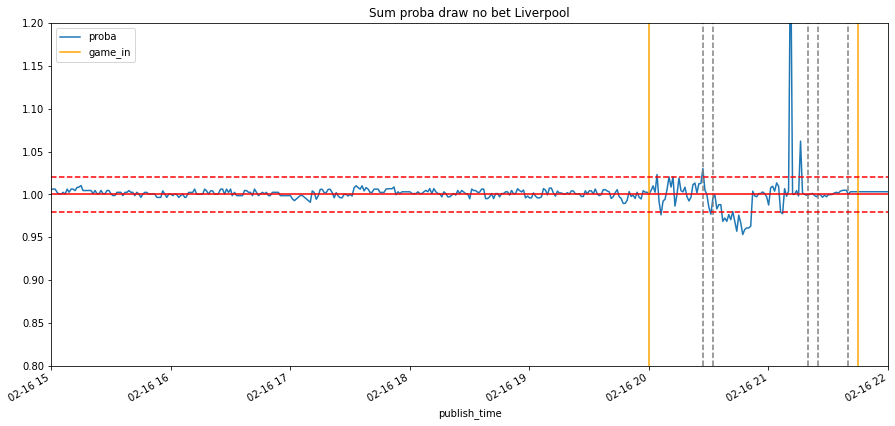

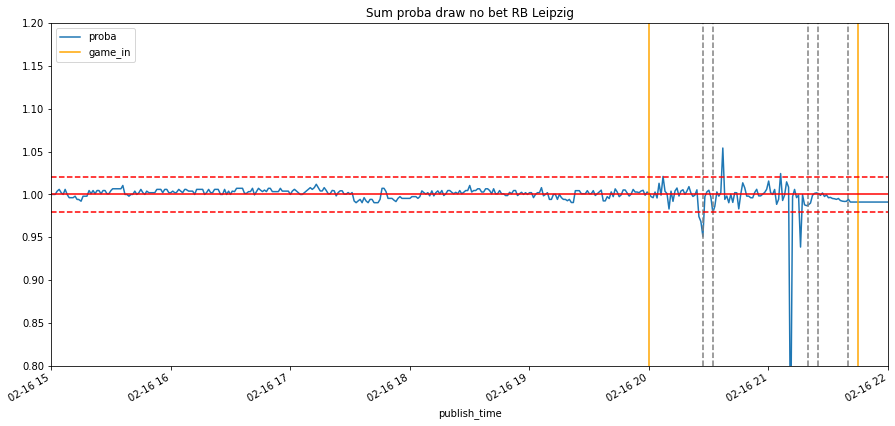

In [48]:
for runner_name in df_game.loc[df_game["market_type"]=="MATCH_ODDS","runner_name"].unique():
    if runner_name == "The Draw":
        continue
    
    df_proba_draw_no_bet = get_sum_proba_draw_no_bet(df_game, runner_name=runner_name)
    
    plot_proba_through_time(
        df_game=df_proba_draw_no_bet,
        df_game_filter=None,
        date_time_start_game=start_game_date_time,
        x_lim_hours_start_game=(5, 2),
        y_lim=(.8, 1.2),
        title=f"Sum proba draw no bet {runner_name}",
        plot_game_time_limits=True,
        goal_times=[27, 32, 65, 85, 70],
        arbitrage_bound=.02,
    )

# 3. Win score vs odds

In [49]:
df_game[df_game["market_type"]=="CORRECT_SCORE"]["runner_name"].unique()

array(['0 - 0', '0 - 1', '0 - 2', '0 - 3', '1 - 0', '1 - 1', '1 - 2',
       '1 - 3', '2 - 0', '2 - 1', '2 - 2', '2 - 3', '3 - 0', '3 - 1',
       '3 - 2', '3 - 3', 'Any Other Away Win', 'Any Other Draw',
       'Any Other Home Win'], dtype=object)

In [50]:
all_away_wins = [
    "0 - 1", "0 - 2", "0 - 3",
    "1 - 2", "1 - 3",
    "2 - 3",
    "Any Other Away Win",
]
away_team = "Liverpool"
# away_team = "RB Leipzig"

df_game["tmp_arbitrage_group"] = np.nan
df_game.loc[
    (df_game["market_type"]=="CORRECT_SCORE")
    & (df_game["runner_name"].isin(all_away_wins)),
    "tmp_arbitrage_group"] = 1
df_game.loc[
    (df_game["market_type"]=="MATCH_ODDS")
    & (df_game["runner_name"]!=away_team),
    "tmp_arbitrage_group"] = 1

df_proba_win_v_score = df_game[df_game["tmp_arbitrage_group"]==1].groupby("publish_time")["proba"].sum()

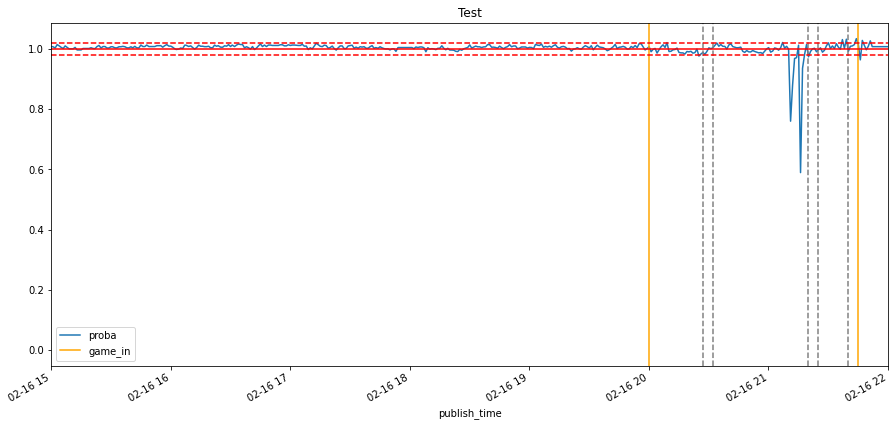

In [51]:
plot_proba_through_time(
    df_game=df_proba_win_v_score,
    df_game_filter=None,
    date_time_start_game=start_game_date_time,
    x_lim_hours_start_game=(5, 2),
    y_lim=None,
    title=f"Test",
    plot_game_time_limits=True,
    goal_times=[27, 32, 65, 85, 70],
    arbitrage_bound=.02,
)